# OpenSim Time-Series Graph Dataset Creation 🚀

This notebook demonstrates how to create time-series graph datasets from OpenSim data with:
- **Node Features**: Joint angles (with velocity and acceleration)
- **Edge Features**: Muscle properties, joint distances, anatomical connections
- **Time-Series Structure**: Sequential graphs for temporal learning

## 🎯 What We'll Build
1. **Parse OpenSim Data**: Load model (.osim) and motion (.mot) files
2. **Create Joint-Angle Graphs**: Each coordinate becomes a graph node
3. **Add Muscle Edge Features**: Use OpenSim muscle properties for edge attributes
4. **Generate Time Series**: Create sequences for temporal graph learning
5. **Export Dataset**: Save for graph neural network training

Let's build this enhanced graph dataset!

In [82]:

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.data import Data
import warnings
import json
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root))

# Import our enhanced OpenSim components
from graphmechanics.utils.opensim_parser import (
    OpenSimParser, 
    OpenSimModelParser, 
    OpenSimMotionParser
)
from graphmechanics.data.opensim_time_series_graph_builder import OpenSimTimeSeriesGraphBuilder

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully!")
print(f"📁 Project root: {project_root}")

# Find test data
test_dir = project_root / "experiments" / "motion_prediction_exp_20250803_200025"
data_dir = project_root / "Data" / "OpenCapData_7272a71a-e70a-4794-a253-39e11cb7542c"

osim_files = list(test_dir.glob("*.osim"))
mot_files = list(data_dir.rglob("*.mot"))

print(f"\n🎯 Available Data:")
print(f"📄 .osim files: {len(osim_files)}")  
print(f"📈 .mot files: {len(mot_files)}")

# Select files for demonstration
test_osim = str(osim_files[0]) if osim_files else None
test_mot = str(mot_files[0]) if mot_files else None

print(f"\n📋 Selected Files:")
if test_osim:
    print(f"   Model: {Path(test_osim).name}")
if test_mot:  
    print(f"   Motion: {Path(test_mot).name}")

## 1. Parse OpenSim Model for Muscle Properties

if test_osim:
    print("🔄 Loading OpenSim Model for Muscle Analysis...")
    
    # Create model parser to extract muscle properties
    model_parser = OpenSimModelParser(test_osim)
    
    print(f"✅ Model loaded: {model_parser.model_name}")
    print(f"📊 Model Structure:")
    print(f"   🦴 Bodies: {len(model_parser.bodies)}")
    print(f"   🔗 Joints: {len(model_parser.joints)}")  
    print(f"   📐 Coordinates: {len(model_parser.coordinates)}")
    print(f"   💪 Muscles: {len(model_parser.muscles)}")
    
    # Get muscle summary for edge features
    muscle_summary = model_parser.get_muscle_summary()
    if muscle_summary:
        print(f"\n💪 Muscle Properties (first 5):")
        for i, (muscle_name, muscle_info) in enumerate(list(muscle_summary.items())[:5]):
            max_force = muscle_info.get('max_force', 0)
            fiber_length = muscle_info.get('fiber_length', 0)
            path_points = muscle_info.get('path_points', 0)
            print(f"   {i+1}. {muscle_name}:")
            print(f"      Force: {max_force:.0f}N, Fiber: {fiber_length:.3f}m, Points: {path_points}")
    
    # Get joint hierarchy for connectivity
    joint_hierarchy = model_parser.get_joint_hierarchy()
    print(f"\n🔗 Joint Hierarchy (first 3):")
    for i, (joint_name, joint_info) in enumerate(list(joint_hierarchy.items())[:3]):
        parent = joint_info.get('parent_body', 'N/A')
        child = joint_info.get('child_body', 'N/A')
        dof = joint_info.get('dof', 0)
        print(f"   {i+1}. {joint_name}: {parent} → {child} ({dof} DOF)")
        
else:
    print("❌ No .osim file found")
    model_parser = None

✅ Libraries imported successfully!
📁 Project root: /home/funsega/GraphMechanics

🎯 Available Data:
📄 .osim files: 1
📈 .mot files: 5

📋 Selected Files:
   Model: LaiUhlrich2022_scaled.osim
   Motion: run.mot
🔄 Loading OpenSim Model for Muscle Analysis...
Successfully parsed OpenSim model: LaiUhlrich2022_scaled
  Bodies: 22
  Joints: 22
  Coordinates: 35
  Muscles: 80
✅ Model loaded: LaiUhlrich2022_scaled
📊 Model Structure:
   🦴 Bodies: 22
   🔗 Joints: 22
   📐 Coordinates: 35
   💪 Muscles: 80

💪 Muscle Properties (first 5):
   1. addbrev_r:
      Force: 626N, Fiber: 0.122m, Points: 2
   2. addlong_r:
      Force: 917N, Fiber: 0.120m, Points: 2
   3. addmagDist_r:
      Force: 597N, Fiber: 0.187m, Points: 2
   4. addmagIsch_r:
      Force: 597N, Fiber: 0.164m, Points: 2
   5. addmagMid_r:
      Force: 597N, Fiber: 0.151m, Points: 2

🔗 Joint Hierarchy (first 3):
   1. ankle_r: tibia_r_offset → talus_r_offset (1 DOF)
   2. subtalar_r: talus_r_offset → calcn_r_offset (1 DOF)
   3. mtp_r: cal

In [83]:

## 2. Parse Motion Data with Joint Angles

if test_mot:
    print("\n🔄 Loading Motion Data for Joint Angles...")
    
    # Create motion parser
    motion_parser = OpenSimMotionParser(test_mot)
    
    print(f"✅ Motion data loaded!")
    print(f"📊 Motion Structure:")
    print(f"   ⏱️  Duration: {motion_parser.get_duration():.2f} seconds")
    print(f"   📊 Frames: {motion_parser.n_rows}")
    print(f"   📐 Coordinates: {len(motion_parser.coordinate_names)}")
    print(f"   🌡️  Units: {'degrees' if motion_parser.in_degrees else 'radians'}")
    
    # Show coordinate types for node features
    print(f"\n📐 Joint Coordinates (nodes) - First 10:")
    for i, coord_name in enumerate(motion_parser.coordinate_names[:10], 1):
        if coord_name != 'time':
            print(f"   {i:2d}. {coord_name}")
    
    remaining = len([c for c in motion_parser.coordinate_names if c != 'time']) - 10
    if remaining > 0:
        print(f"   ... and {remaining} more coordinates")
        
else:
    print("❌ No .mot file found")
    motion_parser = None



🔄 Loading Motion Data for Joint Angles...
Successfully parsed motion file: run.mot
  Duration: 1.55 seconds
  Frames: 94
  Coordinates: 34
  Units: degrees (rotational)
✅ Motion data loaded!
📊 Motion Structure:
   ⏱️  Duration: 1.55 seconds
   📊 Frames: 94
   📐 Coordinates: 34
   🌡️  Units: degrees

📐 Joint Coordinates (nodes) - First 10:
    2. pelvis_tilt
    3. pelvis_list
    4. pelvis_rotation
    5. pelvis_tx
    6. pelvis_ty
    7. pelvis_tz
    8. hip_flexion_r
    9. hip_adduction_r
   10. hip_rotation_r
   ... and 23 more coordinates


In [84]:


## 3. Create Time-Series Graph Builder

if model_parser and motion_parser:
    print("\n🔄 Creating Enhanced Time-Series Graph Builder...")
    
    # Initialize the enhanced graph builder with model information
    graph_builder = OpenSimTimeSeriesGraphBuilder(model_parser=model_parser)
    
    print("✅ Graph builder initialized with:")
    print("   🎯 Node Features: Joint angles (coordinates)")
    print("   🔗 Edge Features: Muscle properties + joint distances")
    print("   🏗️  Anatomical Connectivity: Based on OpenSim model structure")
    
    # Create individual frame graphs
    print("\n🔄 Generating Time-Series Graphs...")
    
    # Use a shorter time window for demonstration
    time_window = (0.0, 1.0)  # First 1 second
    frame_graphs = graph_builder.create_joint_angle_graphs(
        motion_parser, 
        time_window=time_window,
        frame_step=2  # Sample every 2nd frame for speed
    )
    
    print(f"✅ Generated {len(frame_graphs)} graph frames")
    
    # Analyze first graph structure
    if frame_graphs:
        first_graph = frame_graphs[0]
        print(f"\n📊 Graph Structure Analysis:")
        print(f"   🔸 Nodes (coordinates): {first_graph.x.shape[0]}")
        print(f"   🔗 Edges: {first_graph.edge_index.shape[1]}")
        print(f"   📈 Node features: {first_graph.x.shape[1]} (joint angles)")
        print(f"   🎯 Edge features: {first_graph.edge_attr.shape[1] if first_graph.edge_attr is not None else 0}")
        print(f"   ⏰ Time stamp: {first_graph.time:.3f}s")
        
        # Show edge feature composition
        if first_graph.edge_attr is not None:
            edge_features = first_graph.edge_attr
            print(f"\n🔗 Edge Feature Composition:")
            print(f"   Feature 0 - Joint Distance: {edge_features[:, 0].mean():.2f} ± {edge_features[:, 0].std():.2f}")
            print(f"   Feature 1 - Muscle Force Sum: {edge_features[:, 1].mean():.0f} ± {edge_features[:, 1].std():.0f}")
            print(f"   Feature 2 - Muscle Count: {edge_features[:, 2].mean():.1f} ± {edge_features[:, 2].std():.1f}")
            print(f"   Feature 3 - Same Body: {edge_features[:, 3].mean():.2f} (connection strength)")
            print(f"   Feature 4 - Bilateral Symmetry: {edge_features[:, 4].mean():.2f} (L-R pairing)")
        
        print(f"\n🎉 Ready for Graph Neural Network Training!")
        
else:
    print("❌ Need both model and motion files for enhanced graph building")
    graph_builder = None
    frame_graphs = []



🔄 Creating Enhanced Time-Series Graph Builder...
✅ Graph builder initialized with:
   🎯 Node Features: Joint angles (coordinates)
   🔗 Edge Features: Muscle properties + joint distances
   🏗️  Anatomical Connectivity: Based on OpenSim model structure

🔄 Generating Time-Series Graphs...
✅ Generated 31 graph frames

📊 Graph Structure Analysis:
   🔸 Nodes (coordinates): 34
   🔗 Edges: 488
   📈 Node features: 1 (joint angles)
   🎯 Edge features: 5
   ⏰ Time stamp: 0.000s

🔗 Edge Feature Composition:
   Feature 0 - Joint Distance: 1.51 ± 0.86
   Feature 1 - Muscle Force Sum: 9957 ± 0
   Feature 2 - Muscle Count: 80.0 ± 0.0
   Feature 3 - Same Body: 0.25 (connection strength)
   Feature 4 - Bilateral Symmetry: 0.00 (L-R pairing)

🎉 Ready for Graph Neural Network Training!


In [85]:

## 4. Enhance with Kinematic Derivatives

if frame_graphs and len(frame_graphs) > 2:
    print("\n🔄 Adding Velocity and Acceleration Features...")
    
    # Enhance graphs with derivatives
    enhanced_graphs = graph_builder.enhance_graphs_with_derivatives(
        frame_graphs, 
        dt=1/60  # Assuming 60 Hz sampling
    )
    
    print(f"✅ Enhanced {len(enhanced_graphs)} graphs with derivatives")
    
    # Compare original vs enhanced
    if enhanced_graphs:
        original_features = frame_graphs[0].x.shape[1]
        enhanced_features = enhanced_graphs[0].x.shape[1]
        
        print(f"📈 Feature Enhancement:")
        print(f"   Original: {original_features} features (position only)")
        print(f"   Enhanced: {enhanced_features} features (position + velocity + acceleration)")
        
        # Show sample enhanced features
        sample_graph = enhanced_graphs[5]  # Middle graph
        sample_coord_idx = 0
        sample_features = sample_graph.x[sample_coord_idx]
        
        print(f"\n📊 Sample Enhanced Node Features (coordinate {sample_coord_idx}):")
        print(f"   Position: {sample_features[0].item():.4f}")
        print(f"   Velocity: {sample_features[1].item():.4f}")
        print(f"   Acceleration: {sample_features[2].item():.4f}")
        
        # Use enhanced graphs for further processing
        frame_graphs = enhanced_graphs
        
else:
    print("⚠️ Not enough frames for derivative computation")



🔄 Adding Velocity and Acceleration Features...
✅ Enhanced 31 graphs with derivatives
📈 Feature Enhancement:
   Original: 1 features (position only)
   Enhanced: 3 features (position + velocity + acceleration)

📊 Sample Enhanced Node Features (coordinate 0):
   Position: 0.0000
   Velocity: 0.0000
   Acceleration: 0.0000


In [86]:
## 5. Create Sequence Datasets

if frame_graphs and len(frame_graphs) > 10:
    print("\n🔄 Creating Time-Series Sequences...")
    
    # Create sequences for temporal learning
    sequences = graph_builder.create_sequence_graphs(
        motion_parser,
        sequence_length=10,  # 10 frames per sequence
        overlap=5,           # 5 frames overlap between sequences
        time_window=(0.0, 1.0)  # First 1 second
    )
    
    print(f"✅ Generated {len(sequences)} temporal sequences")
    
    if sequences:
        sample_sequence = sequences[0]
        print(f"\n📊 Sequence Structure:")
        print(f"   📏 Length: {sample_sequence['sequence_length']} frames")
        print(f"   ⏰ Time span: {sample_sequence['start_time']:.3f}s to {sample_sequence['end_time']:.3f}s")
        print(f"   🔢 Frame range: {sample_sequence['start_frame']} to {sample_sequence['end_frame']}")
        
        # Analyze sequence graph properties
        seq_graphs = sample_sequence['graphs']
        print(f"   🔸 Nodes per graph: {seq_graphs[0].x.shape[0]}")
        print(f"   📈 Features per node: {seq_graphs[0].x.shape[1]}")
        print(f"   🔗 Edges per graph: {seq_graphs[0].edge_index.shape[1]}")
        
        print(f"\n🎯 Perfect for Sequential Graph Learning!")
        print(f"   • Autoregressive motion prediction")
        print(f"   • Temporal pattern recognition")
        print(f"   • Dynamic stability analysis")
        
else:
    print("⚠️ Not enough frames for sequence creation")
    sequences = []


🔄 Creating Time-Series Sequences...
✅ Generated 11 temporal sequences

📊 Sequence Structure:
   📏 Length: 10 frames
   ⏰ Time span: 0.000s to 0.150s
   🔢 Frame range: 0 to 9
   🔸 Nodes per graph: 34
   📈 Features per node: 1
   🔗 Edges per graph: 488

🎯 Perfect for Sequential Graph Learning!
   • Autoregressive motion prediction
   • Temporal pattern recognition
   • Dynamic stability analysis



📈 Creating Enhanced Graph Structure Visualizations...


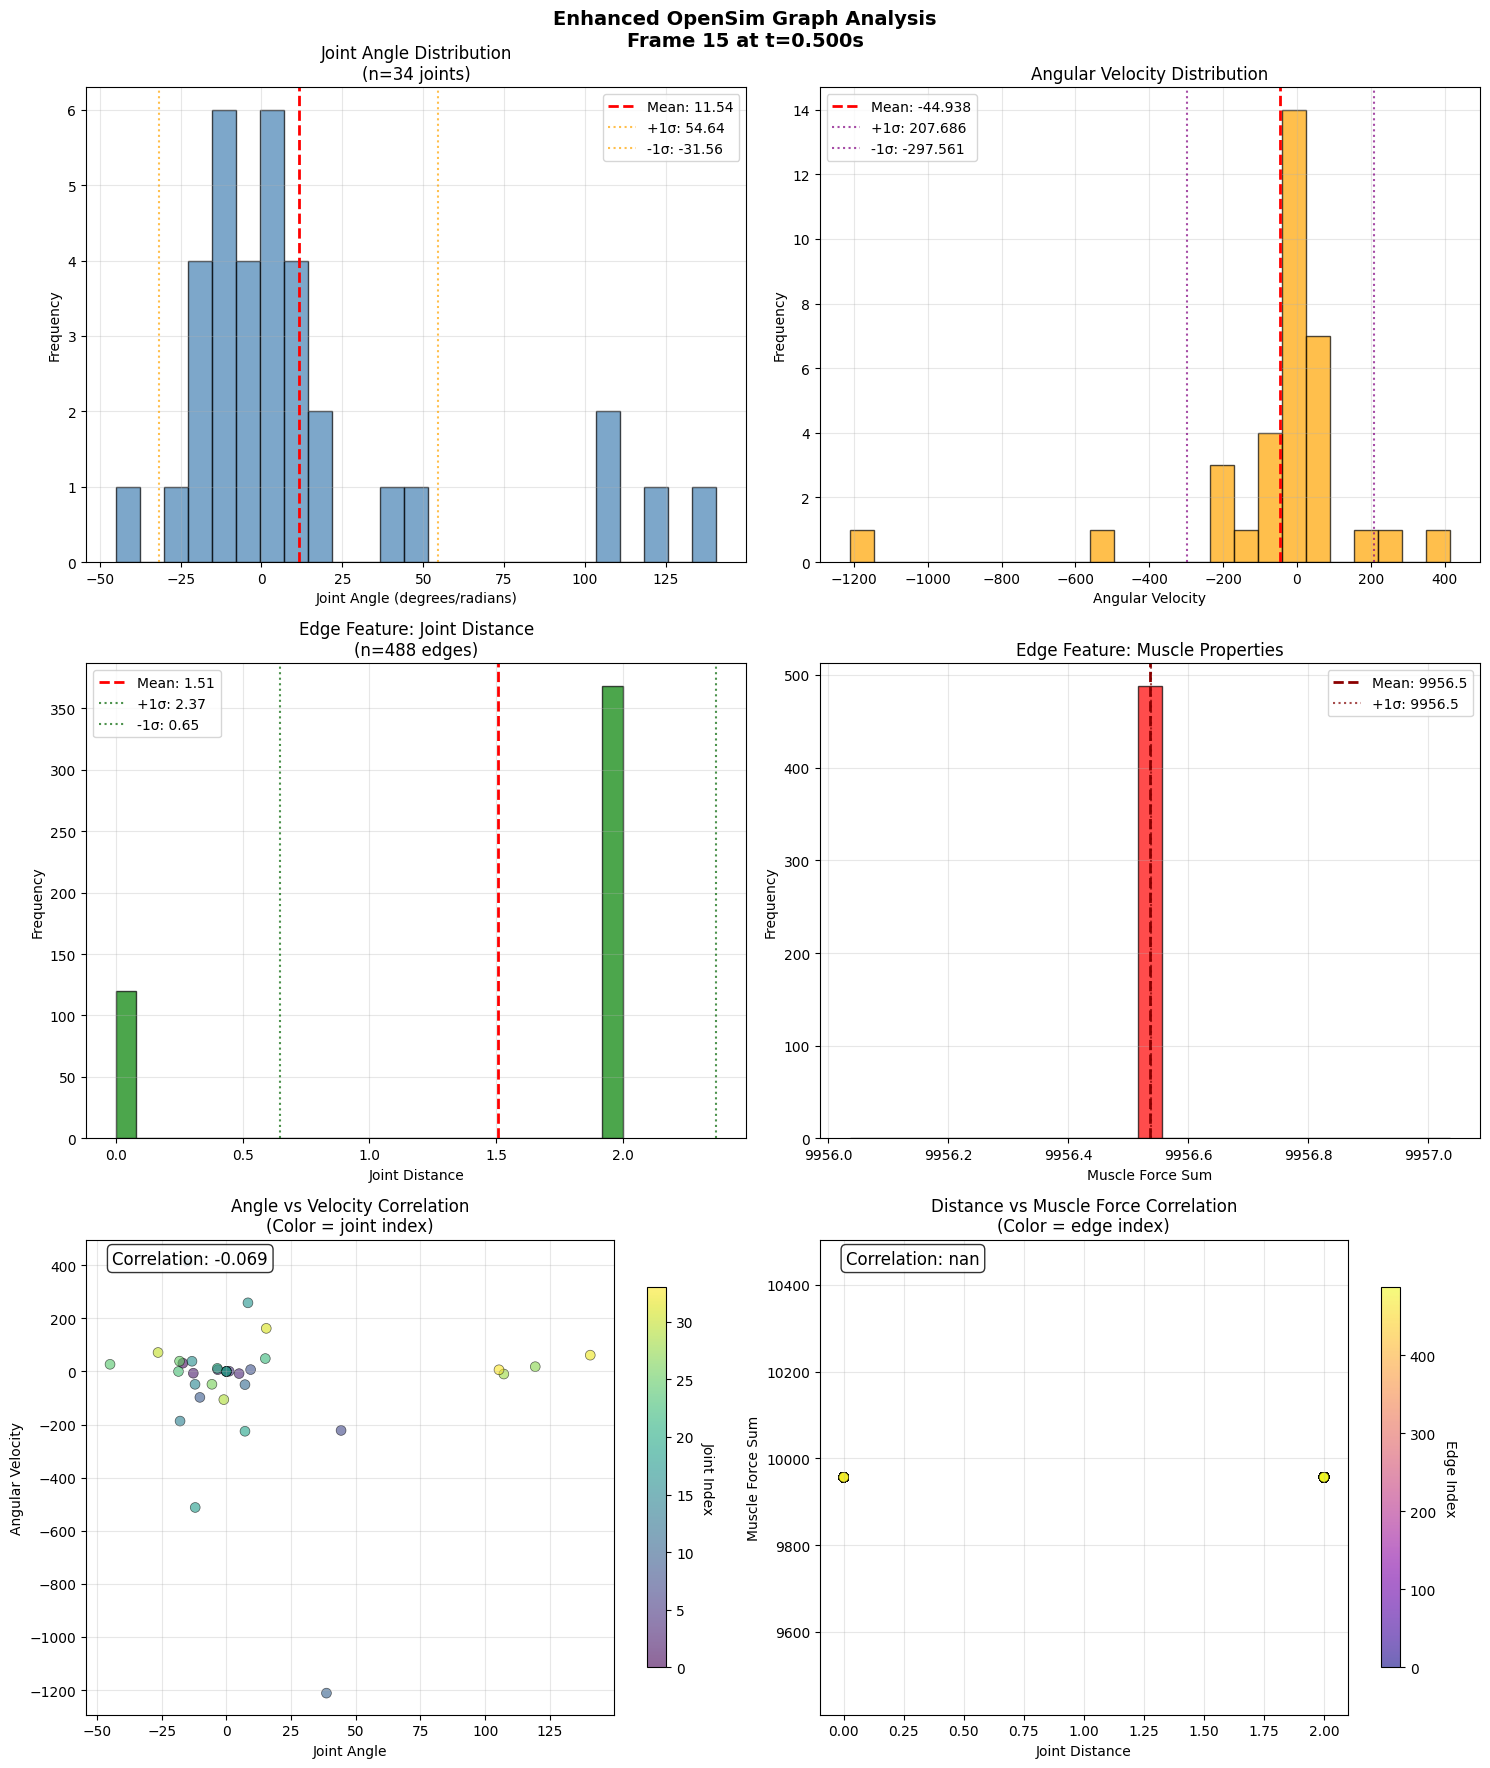


📊 Enhanced Graph Data Statistics:
   🎯 Time: 0.500s (frame 15)
   🔸 Nodes: 34 joints
   📈 Node features: 3 per joint
   🔗 Edges: 488 connections
   📊 Edge features: 5 per connection

📈 Node Feature Ranges:
   🎯 Joint angles: [-44.965, 140.615]
   ⚡ Angular velocities: [-1211.485, 414.654]
   🚀 Angular accelerations: [-34011.184, 46189.117]

🔗 Edge Feature Ranges:
   📏 Joint distances: [0.000, 2.000]
   💪 Muscle forces: [9956.5, 9956.5]
   🔢 Muscle counts: [80.0, 80.0]
✅ Enhanced graph structure visualizations with data insights created


In [87]:
## 6. Enhanced Graph Structure Visualization with Data

if frame_graphs:
    print("\n📈 Creating Enhanced Graph Structure Visualizations...")
    
    # Analyze node feature distributions
    sample_graph = frame_graphs[len(frame_graphs)//2]  # Middle frame
    node_features = sample_graph.x
    edge_features = sample_graph.edge_attr
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    # Plot 1: Joint angle distribution with statistics
    axes[0, 0].hist(node_features[:, 0].numpy(), bins=25, alpha=0.7, color='steelblue', edgecolor='black')
    mean_angle = node_features[:, 0].mean().item()
    std_angle = node_features[:, 0].std().item()
    axes[0, 0].axvline(mean_angle, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_angle:.2f}')
    axes[0, 0].axvline(mean_angle + std_angle, color='orange', linestyle=':', alpha=0.7, label=f'+1σ: {mean_angle + std_angle:.2f}')
    axes[0, 0].axvline(mean_angle - std_angle, color='orange', linestyle=':', alpha=0.7, label=f'-1σ: {mean_angle - std_angle:.2f}')
    axes[0, 0].set_xlabel('Joint Angle (degrees/radians)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title(f'Joint Angle Distribution\n(n={node_features.shape[0]} joints)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # Plot 2: Velocity distribution with statistics (if available)
    if node_features.shape[1] > 1:
        axes[0, 1].hist(node_features[:, 1].numpy(), bins=25, alpha=0.7, color='orange', edgecolor='black')
        mean_vel = node_features[:, 1].mean().item()
        std_vel = node_features[:, 1].std().item()
        axes[0, 1].axvline(mean_vel, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_vel:.3f}')
        axes[0, 1].axvline(mean_vel + std_vel, color='purple', linestyle=':', alpha=0.7, label=f'+1σ: {mean_vel + std_vel:.3f}')
        axes[0, 1].axvline(mean_vel - std_vel, color='purple', linestyle=':', alpha=0.7, label=f'-1σ: {mean_vel - std_vel:.3f}')
        axes[0, 1].set_xlabel('Angular Velocity')
        axes[0, 1].set_ylabel('Frequency') 
        axes[0, 1].set_title('Angular Velocity Distribution')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].legend()
    else:
        axes[0, 1].text(0.5, 0.5, 'No Velocity Data\nAvailable', 
                       ha='center', va='center', transform=axes[0, 1].transAxes,
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[0, 1].set_title('Angular Velocity Distribution')
    
    # Plot 3: Edge feature analysis with enhanced statistics
    if edge_features is not None:
        edge_distances = edge_features[:, 0].numpy()
        axes[1, 0].hist(edge_distances, bins=25, alpha=0.7, color='green', edgecolor='black')
        mean_dist = np.mean(edge_distances)
        std_dist = np.std(edge_distances)
        axes[1, 0].axvline(mean_dist, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_dist:.2f}')
        axes[1, 0].axvline(mean_dist + std_dist, color='darkgreen', linestyle=':', alpha=0.7, label=f'+1σ: {mean_dist + std_dist:.2f}')
        axes[1, 0].axvline(mean_dist - std_dist, color='darkgreen', linestyle=':', alpha=0.7, label=f'-1σ: {mean_dist - std_dist:.2f}')
        axes[1, 0].set_xlabel('Joint Distance')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title(f'Edge Feature: Joint Distance\n(n={len(edge_distances)} edges)')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()
        
        # Plot 4: Muscle force distribution with enhanced statistics
        if edge_features.shape[1] > 1:
            muscle_forces = edge_features[:, 1].numpy()
            axes[1, 1].hist(muscle_forces, bins=25, alpha=0.7, color='red', edgecolor='black')
            mean_force = np.mean(muscle_forces)
            std_force = np.std(muscle_forces)
            axes[1, 1].axvline(mean_force, color='darkred', linestyle='--', linewidth=2, label=f'Mean: {mean_force:.1f}')
            axes[1, 1].axvline(mean_force + std_force, color='maroon', linestyle=':', alpha=0.7, label=f'+1σ: {mean_force + std_force:.1f}')
            axes[1, 1].set_xlabel('Muscle Force Sum')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].set_title('Edge Feature: Muscle Properties')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].legend()
        else:
            axes[1, 1].text(0.5, 0.5, 'No Muscle Data\nAvailable', 
                           ha='center', va='center', transform=axes[1, 1].transAxes,
                           fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            axes[1, 1].set_title('Edge Feature: Muscle Properties')
    else:
        # No edge attributes available
        for ax in [axes[1, 0], axes[1, 1]]:
            ax.text(0.5, 0.5, 'No Edge Features\nAvailable', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1, 0].set_title('Edge Feature: Joint Distance')
        axes[1, 1].set_title('Edge Feature: Muscle Properties')
    
    # Plot 5: Node feature correlation (if multiple features available)
    if node_features.shape[1] > 1:
        # Scatter plot of angle vs velocity
        angles = node_features[:, 0].numpy()
        velocities = node_features[:, 1].numpy()
        
        scatter = axes[2, 0].scatter(angles, velocities, alpha=0.6, c=range(len(angles)), 
                                   cmap='viridis', s=50, edgecolors='black', linewidth=0.5)
        
        # Add correlation coefficient
        correlation = np.corrcoef(angles, velocities)[0, 1]
        axes[2, 0].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                       transform=axes[2, 0].transAxes, fontsize=12, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        axes[2, 0].set_xlabel('Joint Angle')
        axes[2, 0].set_ylabel('Angular Velocity')
        axes[2, 0].set_title('Angle vs Velocity Correlation\n(Color = joint index)')
        axes[2, 0].grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[2, 0], shrink=0.8)
        cbar.set_label('Joint Index', rotation=270, labelpad=15)
        
    else:
        axes[2, 0].text(0.5, 0.5, 'Need Velocity Data\nfor Correlation Analysis', 
                       ha='center', va='center', transform=axes[2, 0].transAxes,
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[2, 0].set_title('Angle vs Velocity Correlation')
    
    # Plot 6: Edge feature correlation (if multiple edge features available)
    if edge_features is not None and edge_features.shape[1] > 1:
        # Scatter plot of distance vs muscle force
        distances = edge_features[:, 0].numpy()
        forces = edge_features[:, 1].numpy()
        
        scatter2 = axes[2, 1].scatter(distances, forces, alpha=0.6, c=range(len(distances)), 
                                    cmap='plasma', s=50, edgecolors='black', linewidth=0.5)
        
        # Add correlation coefficient
        edge_correlation = np.corrcoef(distances, forces)[0, 1]
        axes[2, 1].text(0.05, 0.95, f'Correlation: {edge_correlation:.3f}', 
                       transform=axes[2, 1].transAxes, fontsize=12, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        axes[2, 1].set_xlabel('Joint Distance')
        axes[2, 1].set_ylabel('Muscle Force Sum')
        axes[2, 1].set_title('Distance vs Muscle Force Correlation\n(Color = edge index)')
        axes[2, 1].grid(True, alpha=0.3)
        
        # Add colorbar
        cbar2 = plt.colorbar(scatter2, ax=axes[2, 1], shrink=0.8)
        cbar2.set_label('Edge Index', rotation=270, labelpad=15)
        
    else:
        axes[2, 1].text(0.5, 0.5, 'Need Multiple Edge Features\nfor Correlation Analysis', 
                       ha='center', va='center', transform=axes[2, 1].transAxes,
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[2, 1].set_title('Distance vs Muscle Force Correlation')
    
    plt.suptitle(f'Enhanced OpenSim Graph Analysis\nFrame {sample_graph.frame_idx} at t={sample_graph.time:.3f}s', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print enhanced statistics
    print("\n📊 Enhanced Graph Data Statistics:")
    print(f"   🎯 Time: {sample_graph.time:.3f}s (frame {sample_graph.frame_idx})")
    print(f"   🔸 Nodes: {node_features.shape[0]} joints")
    print(f"   📈 Node features: {node_features.shape[1]} per joint")
    if edge_features is not None:
        print(f"   🔗 Edges: {edge_features.shape[0]} connections")
        print(f"   📊 Edge features: {edge_features.shape[1]} per connection")
    
    print(f"\n📈 Node Feature Ranges:")
    print(f"   🎯 Joint angles: [{node_features[:, 0].min().item():.3f}, {node_features[:, 0].max().item():.3f}]")
    if node_features.shape[1] > 1:
        print(f"   ⚡ Angular velocities: [{node_features[:, 1].min().item():.3f}, {node_features[:, 1].max().item():.3f}]")
    if node_features.shape[1] > 2:
        print(f"   🚀 Angular accelerations: [{node_features[:, 2].min().item():.3f}, {node_features[:, 2].max().item():.3f}]")
    
    if edge_features is not None:
        print(f"\n🔗 Edge Feature Ranges:")
        print(f"   📏 Joint distances: [{edge_features[:, 0].min().item():.3f}, {edge_features[:, 0].max().item():.3f}]")
        if edge_features.shape[1] > 1:
            print(f"   💪 Muscle forces: [{edge_features[:, 1].min().item():.1f}, {edge_features[:, 1].max().item():.1f}]")
        if edge_features.shape[1] > 2:
            print(f"   🔢 Muscle counts: [{edge_features[:, 2].min().item():.1f}, {edge_features[:, 2].max().item():.1f}]")
    
    print("✅ Enhanced graph structure visualizations with data insights created")


🕸️ Creating Enhanced Graph Connectivity Visualization...


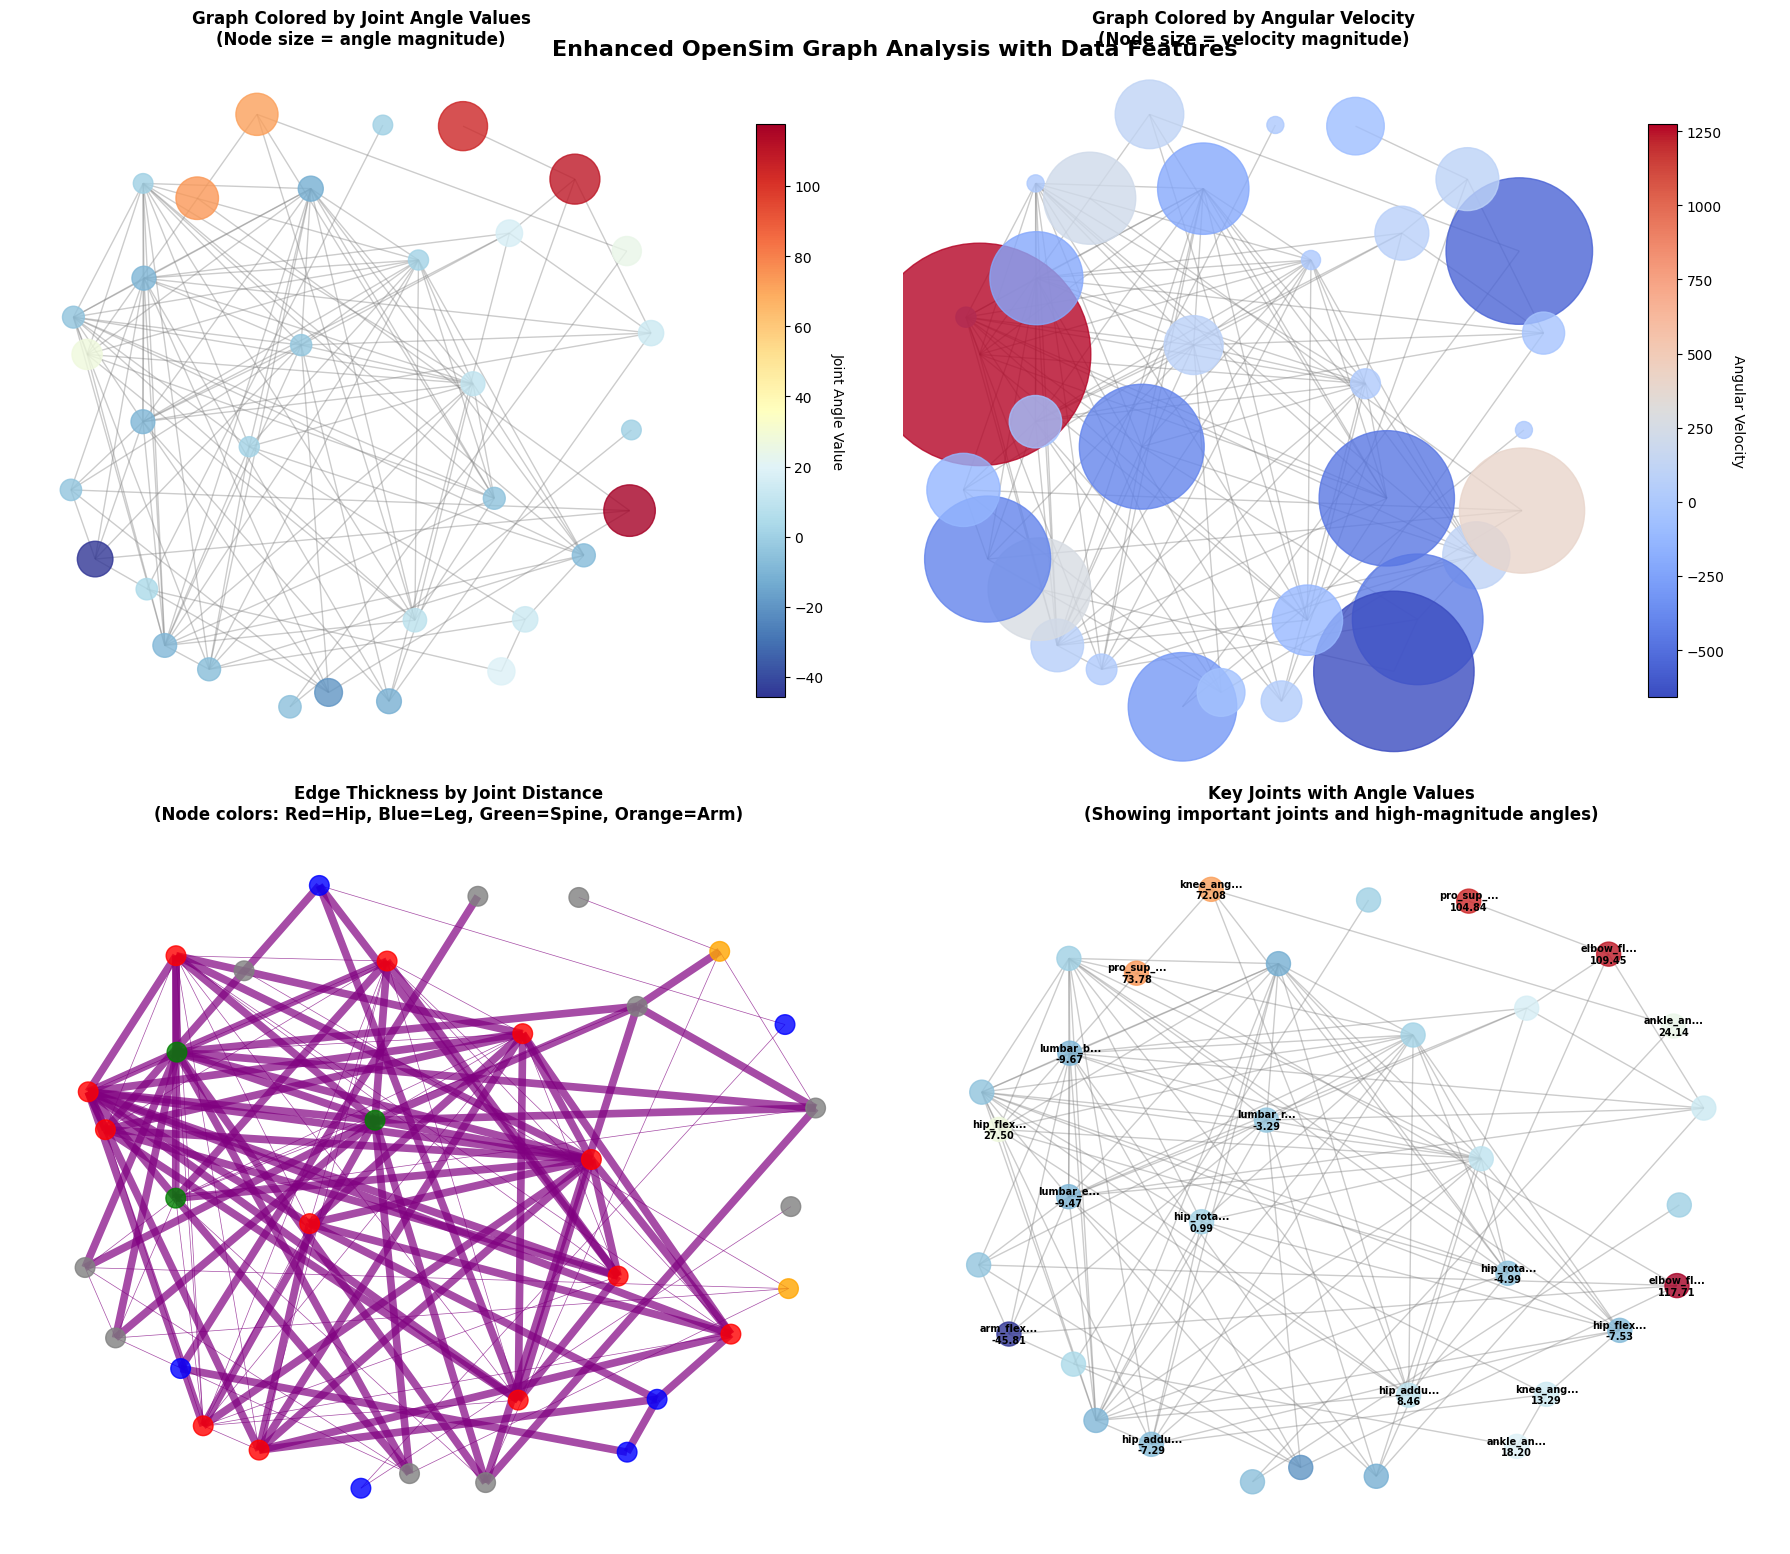


📊 Enhanced Graph Statistics with Data:
   🔸 Nodes (joints): 33
   🔗 Edges (connections): 122
   📊 Average degree: 7.39
   🌐 Connected components: 1
   📏 Graph density: 0.231

📈 Node Feature Statistics:
   🎯 Joint angles: 13.884 ± 37.677
   🔄 Angle range: [-45.807, 117.706]
   ⚡ Angular velocities: -41.267 ± 329.643
   🔄 Velocity range: [-659.590, 1275.107]

🔗 Edge Feature Statistics:
   📏 Joint distances: 1.508 ± 0.861
   🔄 Distance range: [0.000, 2.000]
   💪 Muscle forces: 9956.5 ± 0.0

🌐 Graph Connectivity:
   📐 Diameter: 10
   📍 Average path length: 3.26
✅ Enhanced graph connectivity visualization with data features created


In [88]:
## 6.2 Enhanced Graph Connectivity with Data Features

if frame_graphs:
    try:
        import networkx as nx
        
        print("\n🕸️ Creating Enhanced Graph Connectivity Visualization...")
        
        # Use first graph for connectivity visualization
        sample_graph = frame_graphs[0]
        edge_index = sample_graph.edge_index
        coordinate_names = sample_graph.coordinate_names
        node_features = sample_graph.x
        edge_features = sample_graph.edge_attr
        
        # Create NetworkX graph with data
        G = nx.Graph()
        
        # Add nodes with coordinate names and feature data
        for i, coord_name in enumerate(coordinate_names):
            if coord_name != 'time' and i < node_features.shape[0]:  # Skip time coordinate
                node_value = node_features[i, 0].item()  # Joint angle value
                velocity = node_features[i, 1].item() if node_features.shape[1] > 1 else 0
                G.add_node(i, name=coord_name, angle=node_value, velocity=velocity)
        
        # Add edges with feature data
        edge_list = edge_index.t().numpy()
        edge_weights = []
        
        for idx, edge in enumerate(edge_list):
            if (edge[0] < len(coordinate_names) and edge[1] < len(coordinate_names) and 
                coordinate_names[edge[0]] != 'time' and coordinate_names[edge[1]] != 'time' and
                edge[0] < node_features.shape[0] and edge[1] < node_features.shape[0]):
                
                # Get edge weight from edge features (joint distance)
                edge_weight = 1.0  # Default weight
                if edge_features is not None and idx < edge_features.shape[0]:
                    edge_weight = edge_features[idx, 0].item()  # Joint distance
                
                G.add_edge(edge[0], edge[1], weight=edge_weight)
                edge_weights.append(edge_weight)
        
        # Create visualization with multiple subplots
        fig, axes = plt.subplots(2, 2, figsize=(18, 16))
        
        # Use spring layout for better visualization
        pos = nx.spring_layout(G, k=3, iterations=50, seed=42)
        
        # Plot 1: Node colors by joint angle values
        ax1 = axes[0, 0]
        plt.sca(ax1)
        
        node_angles = [G.nodes[node]['angle'] for node in G.nodes()]
        node_colors_angle = plt.cm.RdYlBu_r(plt.Normalize()(node_angles))
        node_sizes = [200 + abs(angle) * 10 for angle in node_angles]  # Size by angle magnitude
        
        nx.draw_networkx_nodes(G, pos, node_color=node_colors_angle, node_size=node_sizes, alpha=0.8)
        nx.draw_networkx_edges(G, pos, alpha=0.4, width=1, edge_color='gray')
        
        # Add colorbar for node angles
        sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(vmin=min(node_angles), vmax=max(node_angles)))
        sm.set_array([])
        cbar1 = plt.colorbar(sm, ax=ax1, shrink=0.8)
        cbar1.set_label('Joint Angle Value', rotation=270, labelpad=15)
        
        ax1.set_title('Graph Colored by Joint Angle Values\n(Node size = angle magnitude)', fontweight='bold')
        ax1.axis('off')
        
        # Plot 2: Node colors by angular velocity (if available)
        ax2 = axes[0, 1]
        plt.sca(ax2)
        
        if node_features.shape[1] > 1:
            node_velocities = [G.nodes[node]['velocity'] for node in G.nodes()]
            node_colors_vel = plt.cm.coolwarm(plt.Normalize()(node_velocities))
            node_sizes_vel = [150 + abs(vel) * 20 for vel in node_velocities]
            
            nx.draw_networkx_nodes(G, pos, node_color=node_colors_vel, node_size=node_sizes_vel, alpha=0.8)
            nx.draw_networkx_edges(G, pos, alpha=0.4, width=1, edge_color='gray')
            
            sm2 = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(node_velocities), vmax=max(node_velocities)))
            sm2.set_array([])
            cbar2 = plt.colorbar(sm2, ax=ax2, shrink=0.8)
            cbar2.set_label('Angular Velocity', rotation=270, labelpad=15)
            
            ax2.set_title('Graph Colored by Angular Velocity\n(Node size = velocity magnitude)', fontweight='bold')
        else:
            ax2.text(0.5, 0.5, 'No Velocity Data\nAvailable', ha='center', va='center', 
                    transform=ax2.transAxes, fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            ax2.set_title('Angular Velocity Visualization', fontweight='bold')
        ax2.axis('off')
        
        # Plot 3: Edge thickness by edge features (joint distance/muscle properties)
        ax3 = axes[1, 0]
        plt.sca(ax3)
        
        # Color nodes by body region for context
        node_colors_region = []
        for node in G.nodes():
            coord_name = coordinate_names[node].lower()
            if any(keyword in coord_name for keyword in ['hip', 'pelvis']):
                node_colors_region.append('red')
            elif any(keyword in coord_name for keyword in ['knee', 'ankle', 'subtalar']):
                node_colors_region.append('blue')
            elif any(keyword in coord_name for keyword in ['lumbar', 'thorax', 'neck']):
                node_colors_region.append('green')
            elif any(keyword in coord_name for keyword in ['shoulder', 'elbow', 'wrist']):
                node_colors_region.append('orange')
            else:
                node_colors_region.append('gray')
        
        nx.draw_networkx_nodes(G, pos, node_color=node_colors_region, node_size=200, alpha=0.8)
        
        # Draw edges with thickness based on edge features
        if edge_features is not None and len(edge_weights) > 0:
            # Normalize edge weights for visualization
            min_weight, max_weight = min(edge_weights), max(edge_weights)
            if max_weight > min_weight:
                normalized_weights = [(w - min_weight) / (max_weight - min_weight) * 5 + 0.5 for w in edge_weights]
            else:
                normalized_weights = [1.0] * len(edge_weights)
            
            edges = list(G.edges())
            for i, edge in enumerate(edges):
                if i < len(normalized_weights):
                    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=normalized_weights[i], 
                                         alpha=0.7, edge_color='purple')
        else:
            nx.draw_networkx_edges(G, pos, alpha=0.6, width=1, edge_color='gray')
        
        ax3.set_title('Edge Thickness by Joint Distance\n(Node colors: Red=Hip, Blue=Leg, Green=Spine, Orange=Arm)', fontweight='bold')
        ax3.axis('off')
        
        # Plot 4: Node labels with feature values
        ax4 = axes[1, 1]
        plt.sca(ax4)
        
        # Draw nodes with feature-based coloring
        nx.draw_networkx_nodes(G, pos, node_color=node_colors_angle, node_size=300, alpha=0.8)
        nx.draw_networkx_edges(G, pos, alpha=0.4, width=1, edge_color='gray')
        
        # Add labels with joint names and values
        labels_with_values = {}
        for node in G.nodes():
            coord_name = coordinate_names[node]
            angle_val = G.nodes[node]['angle']
            
            # Show label for important joints or high-magnitude angles
            if (any(keyword in coord_name.lower() for keyword in ['hip', 'knee', 'ankle', 'lumbar', 'shoulder']) or 
                abs(angle_val) > np.std(node_angles)):
                short_name = coord_name[:8] + ('...' if len(coord_name) > 8 else '')
                labels_with_values[node] = f'{short_name}\n{angle_val:.2f}'
        
        nx.draw_networkx_labels(G, pos, labels_with_values, font_size=7, font_weight='bold')
        
        ax4.set_title('Key Joints with Angle Values\n(Showing important joints and high-magnitude angles)', fontweight='bold')
        ax4.axis('off')
        
        plt.suptitle('Enhanced OpenSim Graph Analysis with Data Features', fontsize=16, fontweight='bold', y=0.95)
        plt.tight_layout()
        plt.show()
        
        # Enhanced graph statistics with data insights
        print(f"\n📊 Enhanced Graph Statistics with Data:")
        print(f"   🔸 Nodes (joints): {G.number_of_nodes()}")
        print(f"   🔗 Edges (connections): {G.number_of_edges()}")
        print(f"   📊 Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")
        print(f"   🌐 Connected components: {nx.number_connected_components(G)}")
        print(f"   📏 Graph density: {nx.density(G):.3f}")
        
        # Node feature statistics
        print(f"\n📈 Node Feature Statistics:")
        print(f"   🎯 Joint angles: {np.mean(node_angles):.3f} ± {np.std(node_angles):.3f}")
        print(f"   🔄 Angle range: [{np.min(node_angles):.3f}, {np.max(node_angles):.3f}]")
        
        if node_features.shape[1] > 1:
            node_velocities = [G.nodes[node]['velocity'] for node in G.nodes()]
            print(f"   ⚡ Angular velocities: {np.mean(node_velocities):.3f} ± {np.std(node_velocities):.3f}")
            print(f"   🔄 Velocity range: [{np.min(node_velocities):.3f}, {np.max(node_velocities):.3f}]")
        
        # Edge feature statistics
        if edge_features is not None and len(edge_weights) > 0:
            print(f"\n🔗 Edge Feature Statistics:")
            print(f"   📏 Joint distances: {np.mean(edge_weights):.3f} ± {np.std(edge_weights):.3f}")
            print(f"   🔄 Distance range: [{np.min(edge_weights):.3f}, {np.max(edge_weights):.3f}]")
            
            if edge_features.shape[1] > 1:
                muscle_forces = edge_features[:, 1].numpy()
                print(f"   💪 Muscle forces: {np.mean(muscle_forces):.1f} ± {np.std(muscle_forces):.1f}")
        
        if nx.is_connected(G):
            print(f"\n🌐 Graph Connectivity:")
            print(f"   📐 Diameter: {nx.diameter(G)}")
            print(f"   📍 Average path length: {nx.average_shortest_path_length(G):.2f}")
        
        print("✅ Enhanced graph connectivity visualization with data features created")
        
    except ImportError:
        print("⚠️ NetworkX not available - install with: pip install networkx")
        print("   Skipping enhanced graph connectivity visualization")
    except Exception as e:
        print(f"⚠️ Error creating enhanced graph visualization: {e}")
        print("   Continuing with other visualizations...")


📈 Creating Motion Time-Series Visualizations...


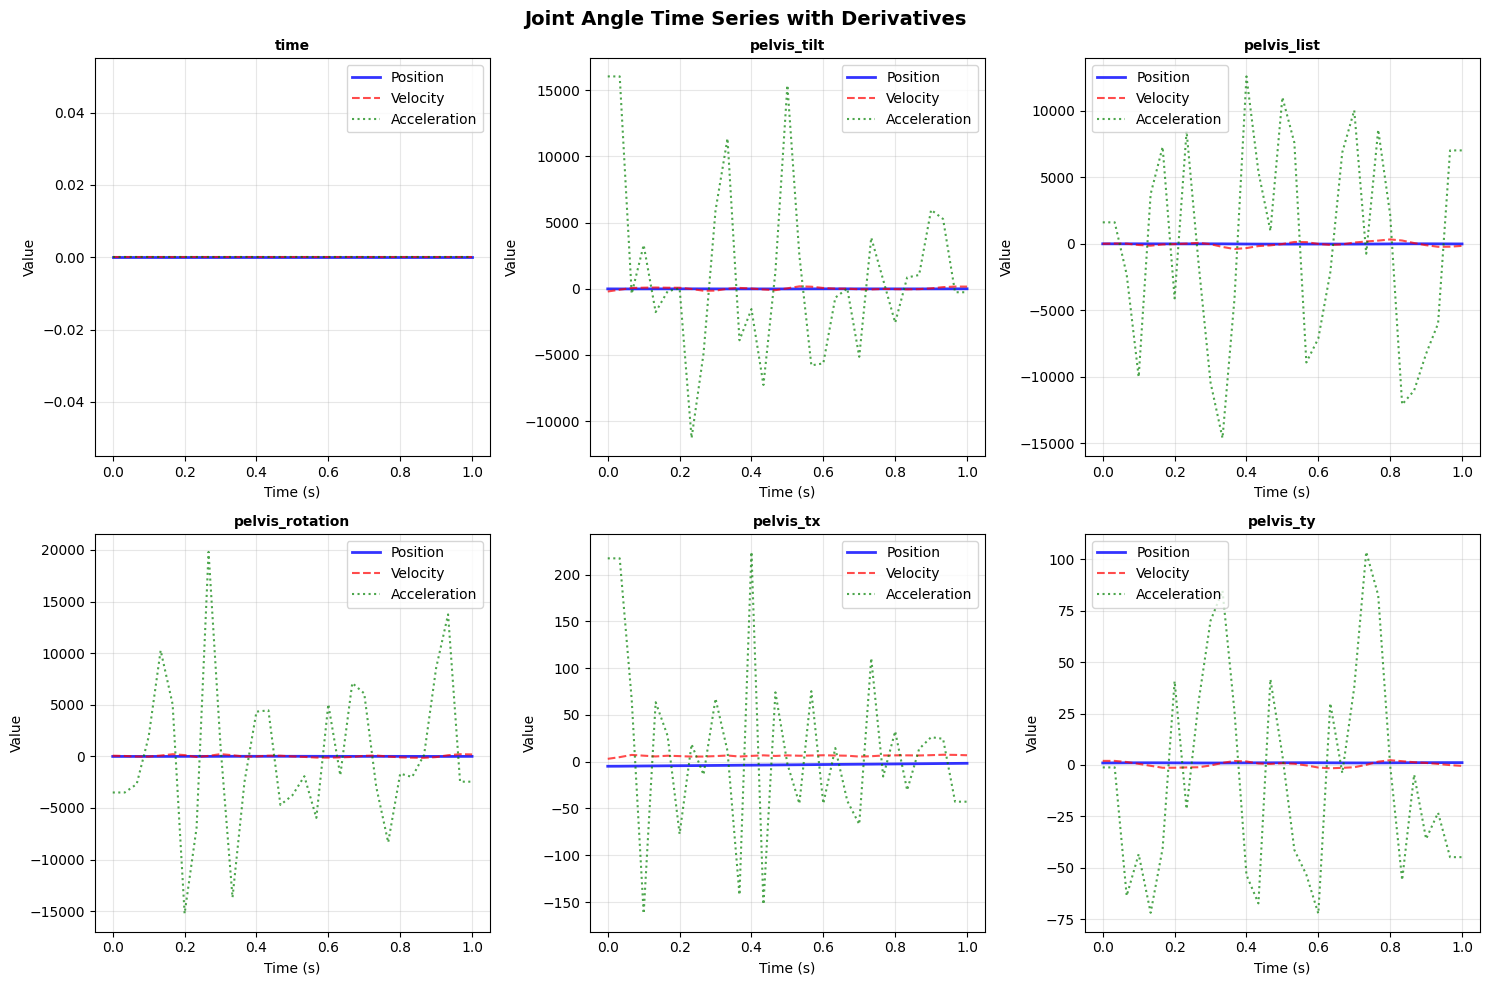

✅ Motion time-series visualizations created

🔥 Creating Enhanced Adjacency Matrix and Edge Analysis...


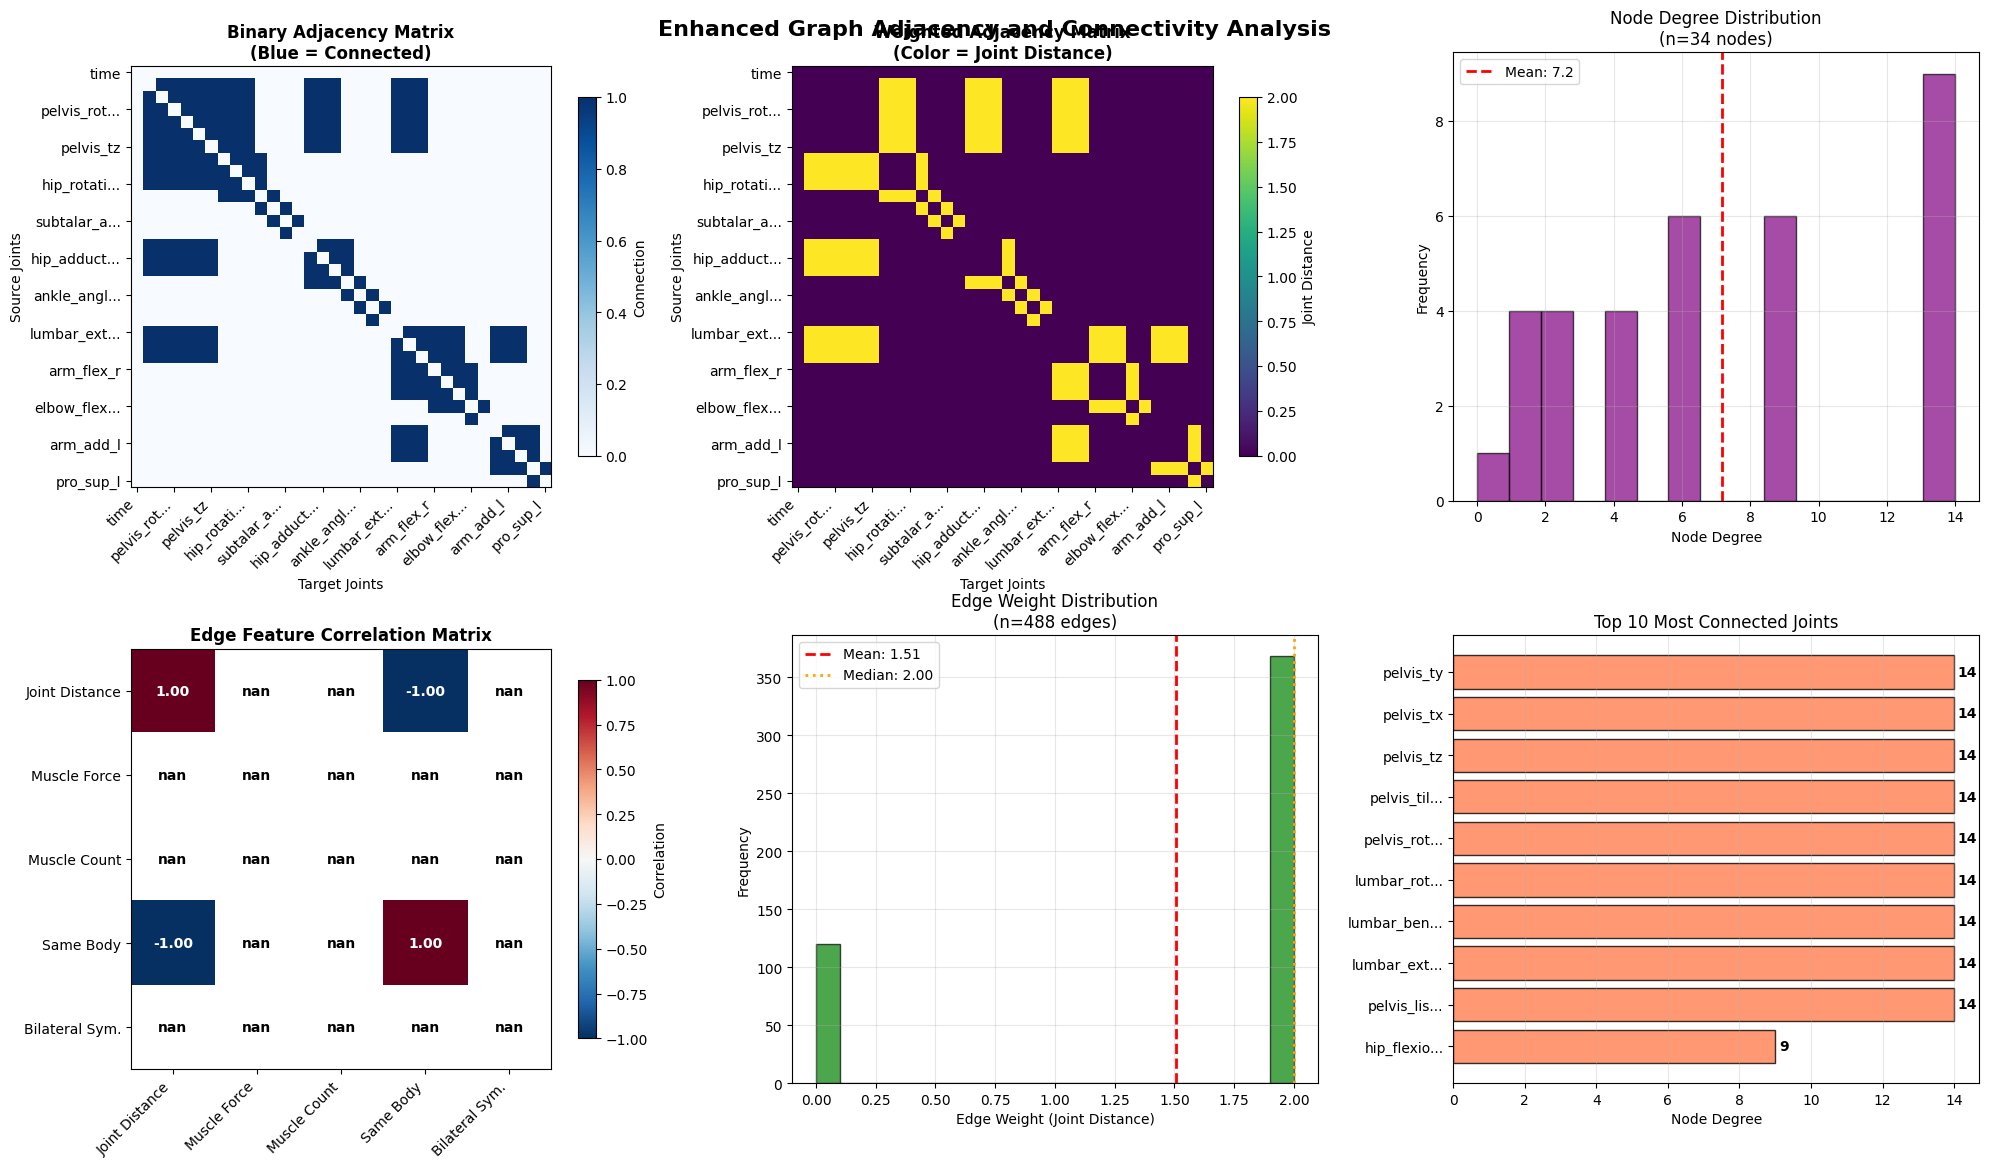


📊 Enhanced Graph Connectivity Statistics:
   🔸 Total nodes: 34
   🔗 Total edges: 488
   📊 Graph density: 0.217
   🎯 Average degree: 7.18 ± 4.85
   🔄 Degree range: [0, 14]

🔗 Edge Weight Statistics:
   📏 Mean distance: 1.508 ± 0.861
   🔄 Distance range: [0.000, 2.000]
   📊 Median distance: 2.000
   💪 Mean muscle force: 9956.5 ± 0.0

🏆 Most Connected Joints:
   1. pelvis_rotation: 14 connections
   2. pelvis_tilt: 14 connections
   3. pelvis_tz: 14 connections
   4. pelvis_tx: 14 connections
   5. pelvis_ty: 14 connections
✅ Enhanced adjacency matrix and edge analysis created


In [89]:
## 6.3 Motion Time Series Visualization

if frame_graphs and len(frame_graphs) > 1:
    print("\n📈 Creating Motion Time-Series Visualizations...")
    
    # Extract time series for first few coordinates
    times = [graph.time for graph in frame_graphs]
    n_coords_to_plot = min(6, len(frame_graphs[0].coordinate_names))
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for coord_idx in range(n_coords_to_plot):
        if coord_idx < len(frame_graphs[0].coordinate_names):
            coord_name = frame_graphs[0].coordinate_names[coord_idx]
            
            # Extract position time series
            positions = [graph.x[coord_idx, 0].item() for graph in frame_graphs]
            axes[coord_idx].plot(times, positions, 'b-', linewidth=2, alpha=0.8, label='Position')
            
            # Extract velocity if available
            if frame_graphs[0].x.shape[1] > 1:
                velocities = [graph.x[coord_idx, 1].item() for graph in frame_graphs]
                axes[coord_idx].plot(times, velocities, 'r--', linewidth=1.5, alpha=0.7, label='Velocity')
            
            # Extract acceleration if available
            if frame_graphs[0].x.shape[1] > 2:
                accelerations = [graph.x[coord_idx, 2].item() for graph in frame_graphs]
                axes[coord_idx].plot(times, accelerations, 'g:', linewidth=1.5, alpha=0.7, label='Acceleration')
            
            axes[coord_idx].set_xlabel('Time (s)')
            axes[coord_idx].set_ylabel('Value')
            axes[coord_idx].set_title(f'{coord_name}', fontsize=10, fontweight='bold')
            axes[coord_idx].grid(True, alpha=0.3)
            axes[coord_idx].legend()
    
    plt.suptitle('Joint Angle Time Series with Derivatives', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ Motion time-series visualizations created")

## 6.4 Enhanced Graph Adjacency Matrix and Edge Analysis

if frame_graphs:
    print("\n🔥 Creating Enhanced Adjacency Matrix and Edge Analysis...")
    
    sample_graph = frame_graphs[0]
    edge_index = sample_graph.edge_index
    coordinate_names = sample_graph.coordinate_names
    edge_features = sample_graph.edge_attr
    n_nodes = len(coordinate_names)
    
    # Create enhanced adjacency matrix with edge weights
    adj_matrix = np.zeros((n_nodes, n_nodes))
    weighted_adj_matrix = np.zeros((n_nodes, n_nodes))
    edge_list = edge_index.t().numpy()
    
    for idx, edge in enumerate(edge_list):
        if edge[0] < n_nodes and edge[1] < n_nodes:
            adj_matrix[edge[0], edge[1]] = 1
            adj_matrix[edge[1], edge[0]] = 1  # Make symmetric for undirected graph
            
            # Add edge weights if available
            if edge_features is not None and idx < edge_features.shape[0]:
                weight = edge_features[idx, 0].item()  # Use joint distance as weight
                weighted_adj_matrix[edge[0], edge[1]] = weight
                weighted_adj_matrix[edge[1], edge[0]] = weight
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Use only coordinate names (truncate long names)
    labels = [name[:10] + ('...' if len(name) > 10 else '') for name in coordinate_names]
    
    # Plot 1: Binary adjacency matrix
    im1 = axes[0, 0].imshow(adj_matrix, cmap='Blues', aspect='equal')
    axes[0, 0].set_title('Binary Adjacency Matrix\n(Blue = Connected)', fontweight='bold')
    axes[0, 0].set_xlabel('Target Joints')
    axes[0, 0].set_ylabel('Source Joints')
    
    # Add sparse tick labels for readability
    tick_indices = range(0, n_nodes, max(1, n_nodes // 10))
    axes[0, 0].set_xticks(tick_indices)
    axes[0, 0].set_yticks(tick_indices)
    axes[0, 0].set_xticklabels([labels[i] for i in tick_indices], rotation=45, ha='right')
    axes[0, 0].set_yticklabels([labels[i] for i in tick_indices])
    
    plt.colorbar(im1, ax=axes[0, 0], shrink=0.8, label='Connection')
    
    # Plot 2: Weighted adjacency matrix (if edge features available)
    if edge_features is not None:
        im2 = axes[0, 1].imshow(weighted_adj_matrix, cmap='viridis', aspect='equal')
        axes[0, 1].set_title('Weighted Adjacency Matrix\n(Color = Joint Distance)', fontweight='bold')
        axes[0, 1].set_xlabel('Target Joints')
        axes[0, 1].set_ylabel('Source Joints')
        
        axes[0, 1].set_xticks(tick_indices)
        axes[0, 1].set_yticks(tick_indices)
        axes[0, 1].set_xticklabels([labels[i] for i in tick_indices], rotation=45, ha='right')
        axes[0, 1].set_yticklabels([labels[i] for i in tick_indices])
        
        plt.colorbar(im2, ax=axes[0, 1], shrink=0.8, label='Joint Distance')
    else:
        axes[0, 1].text(0.5, 0.5, 'No Edge Weights\nAvailable', ha='center', va='center', 
                       transform=axes[0, 1].transAxes, fontsize=14, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[0, 1].set_title('Weighted Adjacency Matrix', fontweight='bold')
    
    # Plot 3: Degree distribution
    node_degrees = np.sum(adj_matrix, axis=1)
    axes[0, 2].hist(node_degrees, bins=15, alpha=0.7, color='purple', edgecolor='black')
    axes[0, 2].axvline(np.mean(node_degrees), color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {np.mean(node_degrees):.1f}')
    axes[0, 2].set_xlabel('Node Degree')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title(f'Node Degree Distribution\n(n={n_nodes} nodes)')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].legend()
    
    # Plot 4: Edge feature correlation analysis
    if edge_features is not None and edge_features.shape[1] > 1:
        edge_features_np = edge_features.numpy()
        feature_names = ['Joint Distance', 'Muscle Force', 'Muscle Count', 'Same Body', 'Bilateral Sym.']
        feature_names = feature_names[:edge_features_np.shape[1]]
        
        # Calculate correlation matrix
        correlation_matrix = np.corrcoef(edge_features_np.T)
        
        im3 = axes[1, 0].imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='equal')
        axes[1, 0].set_title('Edge Feature Correlation Matrix', fontweight='bold')
        
        # Add correlation values as text
        for i in range(len(feature_names)):
            for j in range(len(feature_names)):
                text = axes[1, 0].text(j, i, f'{correlation_matrix[i, j]:.2f}', 
                                     ha='center', va='center', fontweight='bold',
                                     color='white' if abs(correlation_matrix[i, j]) > 0.5 else 'black')
        
        axes[1, 0].set_xticks(range(len(feature_names)))
        axes[1, 0].set_yticks(range(len(feature_names)))
        axes[1, 0].set_xticklabels(feature_names, rotation=45, ha='right')
        axes[1, 0].set_yticklabels(feature_names)
        
        plt.colorbar(im3, ax=axes[1, 0], shrink=0.8, label='Correlation')
        
    else:
        axes[1, 0].text(0.5, 0.5, 'Need Multiple\nEdge Features', ha='center', va='center', 
                       transform=axes[1, 0].transAxes, fontsize=14, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1, 0].set_title('Edge Feature Correlation Matrix', fontweight='bold')
    
    # Plot 5: Edge weight distribution
    if edge_features is not None:
        edge_weights = edge_features[:, 0].numpy()  # Joint distances
        axes[1, 1].hist(edge_weights, bins=20, alpha=0.7, color='green', edgecolor='black')
        axes[1, 1].axvline(np.mean(edge_weights), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {np.mean(edge_weights):.2f}')
        axes[1, 1].axvline(np.median(edge_weights), color='orange', linestyle=':', 
                          linewidth=2, label=f'Median: {np.median(edge_weights):.2f}')
        axes[1, 1].set_xlabel('Edge Weight (Joint Distance)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title(f'Edge Weight Distribution\n(n={len(edge_weights)} edges)')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].legend()
    else:
        axes[1, 1].text(0.5, 0.5, 'No Edge Weights\nAvailable', ha='center', va='center', 
                       transform=axes[1, 1].transAxes, fontsize=14, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1, 1].set_title('Edge Weight Distribution', fontweight='bold')
    
    # Plot 6: Top connected nodes analysis
    top_nodes_idx = np.argsort(node_degrees)[-10:]  # Top 10 most connected nodes
    top_node_names = [labels[i] for i in top_nodes_idx]
    top_node_degrees = node_degrees[top_nodes_idx]
    
    bars = axes[1, 2].barh(range(len(top_node_names)), top_node_degrees, 
                          color='coral', alpha=0.8, edgecolor='black')
    axes[1, 2].set_yticks(range(len(top_node_names)))
    axes[1, 2].set_yticklabels(top_node_names)
    axes[1, 2].set_xlabel('Node Degree')
    axes[1, 2].set_title('Top 10 Most Connected Joints')
    axes[1, 2].grid(True, alpha=0.3, axis='x')
    
    # Add degree values on bars
    for i, (bar, degree) in enumerate(zip(bars, top_node_degrees)):
        axes[1, 2].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                       f'{int(degree)}', va='center', fontweight='bold')
    
    plt.suptitle('Enhanced Graph Adjacency and Connectivity Analysis', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Enhanced statistics
    print(f"\n📊 Enhanced Graph Connectivity Statistics:")
    print(f"   🔸 Total nodes: {n_nodes}")
    print(f"   🔗 Total edges: {len(edge_list)}")
    print(f"   📊 Graph density: {np.sum(adj_matrix) / (n_nodes * (n_nodes - 1)):.3f}")
    print(f"   🎯 Average degree: {np.mean(node_degrees):.2f} ± {np.std(node_degrees):.2f}")
    print(f"   🔄 Degree range: [{int(np.min(node_degrees))}, {int(np.max(node_degrees))}]")
    
    if edge_features is not None:
        edge_weights = edge_features[:, 0].numpy()
        print(f"\n🔗 Edge Weight Statistics:")
        print(f"   📏 Mean distance: {np.mean(edge_weights):.3f} ± {np.std(edge_weights):.3f}")
        print(f"   🔄 Distance range: [{np.min(edge_weights):.3f}, {np.max(edge_weights):.3f}]")
        print(f"   📊 Median distance: {np.median(edge_weights):.3f}")
        
        if edge_features.shape[1] > 1:
            muscle_forces = edge_features[:, 1].numpy()
            print(f"   💪 Mean muscle force: {np.mean(muscle_forces):.1f} ± {np.std(muscle_forces):.1f}")
    
    # Most connected joints
    print(f"\n🏆 Most Connected Joints:")
    for i, (idx, degree) in enumerate(zip(top_nodes_idx[-5:], top_node_degrees[-5:]), 1):
        print(f"   {i}. {coordinate_names[idx]}: {int(degree)} connections")
    
    print("✅ Enhanced adjacency matrix and edge analysis created")


📈 Creating Time-Series Analysis...


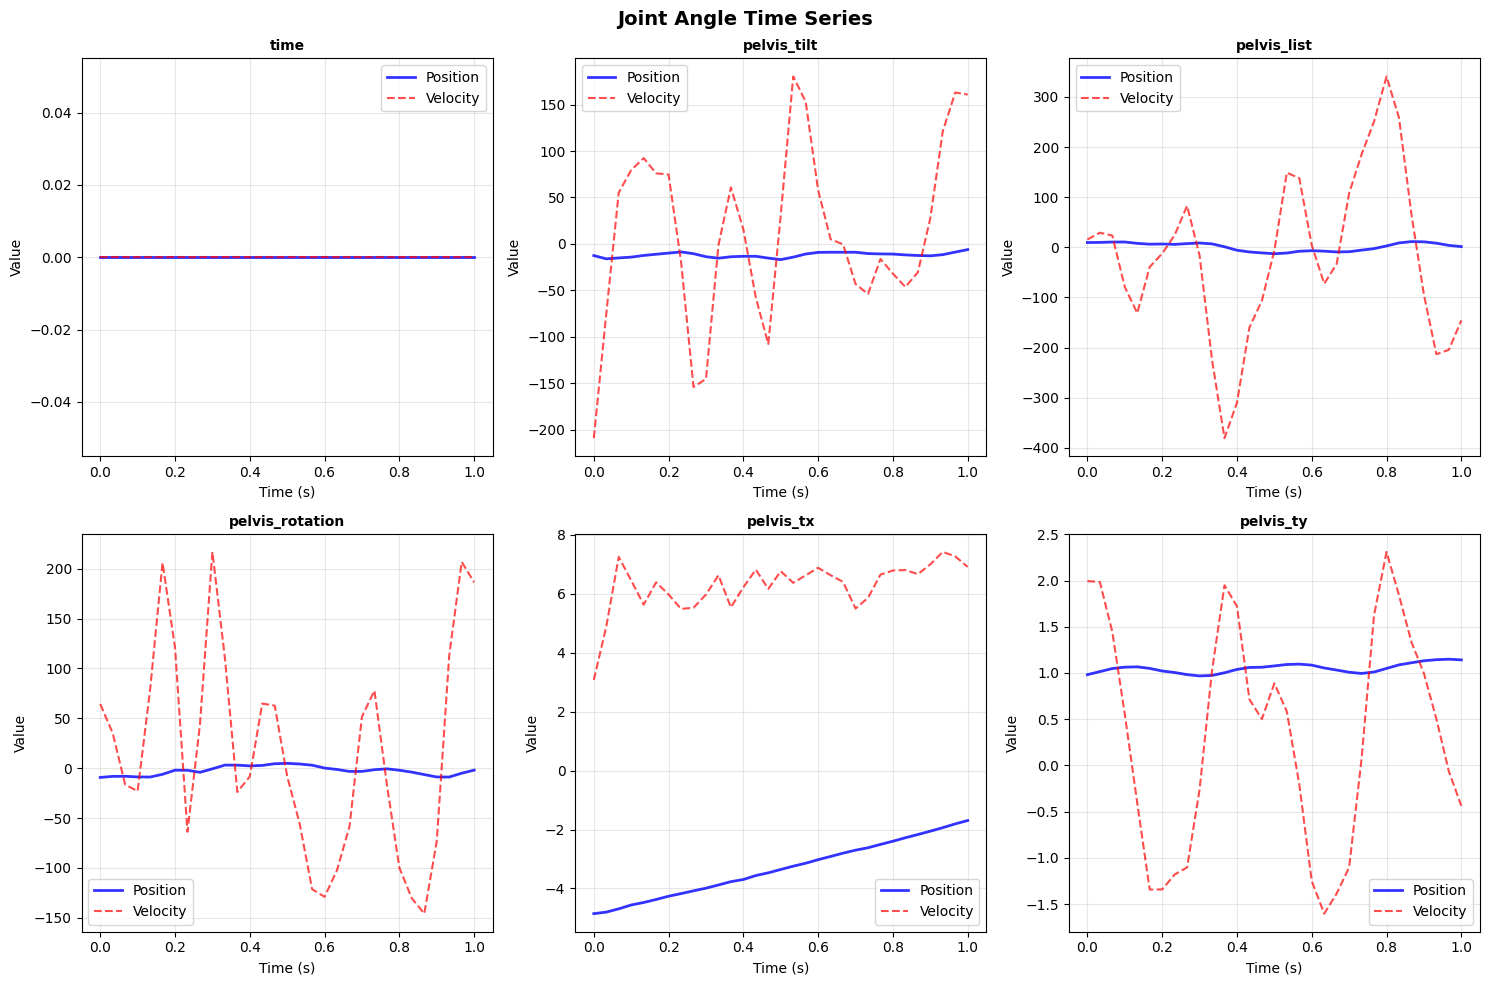

✅ Time-series analysis plots created

💾 Exporting Graph Dataset...
✅ Frame graphs: frame_graphs.npz (31 graphs)
✅ Sequences: sequences.json (11 sequences)
✅ Metadata: dataset_metadata.json

📋 Export Summary:
   📁 Files created: 7
   📊 Total size: 30,470 bytes
   📂 Location: /home/funsega/GraphMechanics/notebooks/../opensim_graph_dataset

🎯 Dataset Ready for Training!
   🧠 Graph Neural Networks
   ⏰ Temporal Sequence Models
   🔮 Motion Prediction Tasks
   📊 Biomechanical Analysis

🚀 How to Load and Use This Dataset:

```python
import numpy as np
import torch
from torch_geometric.data import Data
import json

# Load the dataset
graphs_data = np.load('opensim_graph_dataset/frame_graphs.npz', allow_pickle=True)
graphs = graphs_data['graphs']

# Load metadata
with open('opensim_graph_dataset/dataset_metadata.json', 'r') as f:
    metadata = json.load(f)

# Convert back to PyTorch Geometric format
pyg_graphs = []
for graph_dict in graphs:
    graph = Data(
        x=torch.tensor(graph_dict['

In [90]:


# Plot time series of sample coordinates
if frame_graphs and len(frame_graphs) > 1:
    print("\n📈 Creating Time-Series Analysis...")
    
    # Extract time series for first few coordinates
    times = [graph.time for graph in frame_graphs]
    n_coords_to_plot = min(6, len(frame_graphs[0].coordinate_names))
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for coord_idx in range(n_coords_to_plot):
        if coord_idx < len(frame_graphs[0].coordinate_names):
            coord_name = frame_graphs[0].coordinate_names[coord_idx]
            
            # Extract position time series
            positions = [graph.x[coord_idx, 0].item() for graph in frame_graphs]
            axes[coord_idx].plot(times, positions, 'b-', linewidth=2, alpha=0.8, label='Position')
            
            # Extract velocity if available
            if frame_graphs[0].x.shape[1] > 1:
                velocities = [graph.x[coord_idx, 1].item() for graph in frame_graphs]
                axes[coord_idx].plot(times, velocities, 'r--', linewidth=1.5, alpha=0.7, label='Velocity')
            
            axes[coord_idx].set_xlabel('Time (s)')
            axes[coord_idx].set_ylabel('Value')
            axes[coord_idx].set_title(f'{coord_name}', fontsize=10, fontweight='bold')
            axes[coord_idx].grid(True, alpha=0.3)
            axes[coord_idx].legend()
    
    plt.suptitle('Joint Angle Time Series', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ Time-series analysis plots created")

## 8. Export Dataset

if frame_graphs:
    print("\n💾 Exporting Graph Dataset...")
    
    # Create output directory
    output_dir = Path("../opensim_graph_dataset")
    output_dir.mkdir(exist_ok=True)
    
    try:
        # Save individual graphs
        graph_data = []
        for i, graph in enumerate(frame_graphs):
            graph_dict = {
                'node_features': graph.x.numpy(),
                'edge_index': graph.edge_index.numpy(),
                'edge_attr': graph.edge_attr.numpy() if graph.edge_attr is not None else None,
                'time': graph.time,
                'frame_idx': graph.frame_idx,
                'coordinate_names': graph.coordinate_names
            }
            graph_data.append(graph_dict)
        
        # Save as numpy archive
        graphs_file = output_dir / "frame_graphs.npz"
        np.savez_compressed(graphs_file, graphs=graph_data)
        
        print(f"✅ Frame graphs: {graphs_file.name} ({len(frame_graphs)} graphs)")
        
        # Save sequences if available
        sequences = locals().get('sequences', [])  # Get sequences if they exist
        if sequences:
            sequences_file = output_dir / "sequences.json"
            # Convert sequences to serializable format
            serializable_sequences = []
            for seq in sequences:
                seq_dict = {
                    'start_frame': seq['start_frame'],
                    'end_frame': seq['end_frame'],
                    'start_time': float(seq['start_time']),
                    'end_time': float(seq['end_time']),
                    'sequence_length': seq['sequence_length']
                }
                serializable_sequences.append(seq_dict)
            
            with open(sequences_file, 'w') as f:
                json.dump(serializable_sequences, f, indent=2)
            
            print(f"✅ Sequences: {sequences_file.name} ({len(sequences)} sequences)")
        
        # Save metadata
        metadata = {
            'dataset_info': {
                'source_model': Path(test_osim).name if test_osim else None,
                'source_motion': Path(test_mot).name if test_mot else None,
                'total_frames': len(frame_graphs),
                'time_span': {
                    'start': float(frame_graphs[0].time),
                    'end': float(frame_graphs[-1].time),
                    'duration': float(frame_graphs[-1].time - frame_graphs[0].time)
                }
            },
            'graph_structure': {
                'num_nodes': int(frame_graphs[0].x.shape[0]),
                'num_edges': int(frame_graphs[0].edge_index.shape[1]),
                'node_features': int(frame_graphs[0].x.shape[1]),
                'edge_features': int(frame_graphs[0].edge_attr.shape[1]) if frame_graphs[0].edge_attr is not None else 0
            },
            'feature_description': {
                'node_features': ['joint_angle', 'angular_velocity', 'angular_acceleration'] if frame_graphs[0].x.shape[1] == 3 else ['joint_angle'],
                'edge_features': ['joint_distance', 'muscle_force_sum', 'muscle_count', 'same_body_indicator', 'bilateral_symmetry']
            },
            'model_components': {
                'bodies': len(model_parser.bodies) if model_parser else 0,
                'joints': len(model_parser.joints) if model_parser else 0,
                'muscles': len(model_parser.muscles) if model_parser else 0,
                'coordinates': len(model_parser.coordinates) if model_parser else 0
            },
            'sequences': {
                'total_sequences': len(sequences) if 'sequences' in locals() and sequences else 0,
                'sequence_length': sequences[0]['sequence_length'] if 'sequences' in locals() and sequences else 0,
                'overlap': 5  # frames
            }
        }
        
        metadata_file = output_dir / "dataset_metadata.json"
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"✅ Metadata: {metadata_file.name}")
        
        # List all exports
        exported_files = list(output_dir.glob("*"))
        total_size = sum(f.stat().st_size for f in exported_files if f.is_file())
        
        print(f"\n📋 Export Summary:")
        print(f"   📁 Files created: {len(exported_files)}")
        print(f"   📊 Total size: {total_size:,} bytes")
        print(f"   📂 Location: {output_dir.absolute()}")
        
        print(f"\n🎯 Dataset Ready for Training!")
        print(f"   🧠 Graph Neural Networks")
        print(f"   ⏰ Temporal Sequence Models")
        print(f"   🔮 Motion Prediction Tasks")
        print(f"   📊 Biomechanical Analysis")
        
    except Exception as e:
        print(f"❌ Export error: {e}")

else:
    print("❌ No graphs available for export")

## 8. Loading and Using the Dataset

print("\n🚀 How to Load and Use This Dataset:")

print("""
```python
import numpy as np
import torch
from torch_geometric.data import Data
import json

# Load the dataset
graphs_data = np.load('opensim_graph_dataset/frame_graphs.npz', allow_pickle=True)
graphs = graphs_data['graphs']

# Load metadata
with open('opensim_graph_dataset/dataset_metadata.json', 'r') as f:
    metadata = json.load(f)

# Convert back to PyTorch Geometric format
pyg_graphs = []
for graph_dict in graphs:
    graph = Data(
        x=torch.tensor(graph_dict['node_features'], dtype=torch.float),
        edge_index=torch.tensor(graph_dict['edge_index'], dtype=torch.long),
        edge_attr=torch.tensor(graph_dict['edge_attr'], dtype=torch.float) if graph_dict['edge_attr'] is not None else None
    )
    pyg_graphs.append(graph)

# Use for training
from torch_geometric.loader import DataLoader
loader = DataLoader(pyg_graphs, batch_size=32, shuffle=True)
```
""")

## 🎉 Summary

print(f"\n🎉 OpenSim Time-Series Graph Dataset Creation Complete!")

print(f"\n✅ What We Accomplished:")
print(f"   🎯 Joint-Angle Node Features: Each coordinate is a graph node")
print(f"   🔗 Rich Edge Features: Muscle properties + anatomical distances") 
print(f"   ⏰ Time-Series Structure: Sequential graphs for temporal learning")
print(f"   📈 Enhanced Derivatives: Position, velocity, acceleration")
print(f"   📊 Sequence Generation: Overlapping windows for training")
print(f"   💾 Complete Export: Ready-to-use dataset with metadata")

print(f"\n🚀 Next Steps:")
print(f"   🧠 Train Graph Neural Networks on this rich dataset")
print(f"   🔮 Build autoregressive motion prediction models")
print(f"   📊 Analyze biomechanical patterns in graph space")
print(f"   🎯 Use muscle-informed edge features for better predictions")

print(f"\n🏗️ Dataset Architecture Benefits:")
print(f"   • Anatomically-informed graph structure")
print(f"   • Rich muscle and joint property features")
print(f"   • Time-series ready for sequential learning")
print(f"   • Biomechanically meaningful representations")

print(f"\nThe enhanced OpenSim graph dataset is ready for advanced biomechanical analysis! 🚀")

In [91]:
## 9. Create PyTorch Geometric Dataset

if frame_graphs:
    print("\n🔧 Creating PyTorch Geometric Dataset...")
    
    from torch_geometric.data import Dataset, InMemoryDataset
    import pickle
    import os
    
    class OpenSimGraphDataset(InMemoryDataset):
        """
        Custom PyTorch Geometric Dataset for OpenSim time-series graphs
        """
        def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
            super().__init__(root, transform, pre_transform, pre_filter)
            self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        
        @property
        def raw_file_names(self):
            return ['opensim_graphs.pkl']
        
        @property 
        def processed_file_names(self):
            return ['data.pt']
        
        def download(self):
            # No download needed - data is already processed
            pass
        
        def process(self):
            # Load raw data
            with open(self.raw_paths[0], 'rb') as f:
                raw_data = pickle.load(f)
            
            data_list = []
            for i, graph_info in enumerate(raw_data['graphs']):
                # Create PyTorch Geometric Data object
                data = Data(
                    x=torch.tensor(graph_info['node_features'], dtype=torch.float),
                    edge_index=torch.tensor(graph_info['edge_index'], dtype=torch.long),
                    edge_attr=torch.tensor(graph_info['edge_attr'], dtype=torch.float) if graph_info['edge_attr'] is not None else None,
                    y=torch.tensor([i], dtype=torch.long),  # Frame index as target
                    time=torch.tensor([graph_info['time']], dtype=torch.float),
                    frame_idx=torch.tensor([graph_info['frame_idx']], dtype=torch.long)
                )
                
                # Add metadata as attributes
                data.coordinate_names = graph_info['coordinate_names']
                data_list.append(data)
            
            # Apply pre-filtering and pre-transforms if specified
            if self.pre_filter is not None:
                data_list = [data for data in data_list if self.pre_filter(data)]
            
            if self.pre_transform is not None:
                data_list = [self.pre_transform(data) for data in data_list]
            
            # Collate data
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])
    
    # Prepare dataset directory
    dataset_root = Path("../opensim_pyg_dataset")
    dataset_root.mkdir(exist_ok=True)
    raw_dir = dataset_root / "raw"
    raw_dir.mkdir(exist_ok=True)
    
    # Prepare raw data for the dataset
    raw_data = {
        'graphs': [],
        'metadata': {
            'dataset_info': {
                'source_model': Path(test_osim).name if test_osim else None,
                'source_motion': Path(test_mot).name if test_mot else None,
                'total_frames': len(frame_graphs),
                'time_span': {
                    'start': float(frame_graphs[0].time),
                    'end': float(frame_graphs[-1].time),
                    'duration': float(frame_graphs[-1].time - frame_graphs[0].time)
                }
            },
            'graph_structure': {
                'num_nodes': int(frame_graphs[0].x.shape[0]),
                'num_edges': int(frame_graphs[0].edge_index.shape[1]),
                'node_features': int(frame_graphs[0].x.shape[1]),
                'edge_features': int(frame_graphs[0].edge_attr.shape[1]) if frame_graphs[0].edge_attr is not None else 0
            },
            'feature_description': {
                'node_features': ['joint_angle', 'angular_velocity', 'angular_acceleration'] if frame_graphs[0].x.shape[1] == 3 else ['joint_angle'],
                'edge_features': ['joint_distance', 'muscle_force_sum', 'muscle_count', 'same_body_indicator', 'bilateral_symmetry'] if frame_graphs[0].edge_attr is not None else []
            }
        }
    }
    
    # Convert frame graphs to serializable format
    for graph in frame_graphs:
        graph_dict = {
            'node_features': graph.x.numpy(),
            'edge_index': graph.edge_index.numpy(), 
            'edge_attr': graph.edge_attr.numpy() if graph.edge_attr is not None else None,
            'time': float(graph.time),
            'frame_idx': int(graph.frame_idx),
            'coordinate_names': graph.coordinate_names
        }
        raw_data['graphs'].append(graph_dict)
    
    # Save raw data
    raw_file = raw_dir / "opensim_graphs.pkl"
    with open(raw_file, 'wb') as f:
        pickle.dump(raw_data, f)
    
    print(f"✅ Raw data saved: {raw_file}")
    
    # Create the dataset
    try:
        dataset = OpenSimGraphDataset(root=str(dataset_root))
        
        print(f"✅ PyTorch Geometric Dataset Created!")
        print(f"   📊 Total graphs: {len(dataset)}")
        print(f"   🔸 Nodes per graph: {dataset[0].x.shape[0]}")
        print(f"   📈 Node features: {dataset[0].x.shape[1]}")
        print(f"   🔗 Edges per graph: {dataset[0].edge_index.shape[1]}")
        if dataset[0].edge_attr is not None:
            print(f"   📊 Edge features: {dataset[0].edge_attr.shape[1]}")
        
        # Test dataset functionality
        print(f"\n🧪 Testing Dataset Functionality:")
        sample_data = dataset[0]
        print(f"   ✅ Sample graph loaded successfully")
        print(f"   ⏰ Time: {sample_data.time.item():.3f}s")
        print(f"   📋 Frame index: {sample_data.frame_idx.item()}")
        print(f"   🎯 Target (frame idx): {sample_data.y.item()}")
        print(f"   📐 Coordinate names: {len(sample_data.coordinate_names)} joints")
        
        # Create train/validation split examples
        from torch_geometric.loader import DataLoader
        
        # Split dataset (80% train, 20% validation)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        
        # Create indices for splitting (ensuring temporal order for time-series)
        train_indices = list(range(train_size))
        val_indices = list(range(train_size, len(dataset)))
        
        train_dataset = dataset[train_indices]
        val_dataset = dataset[val_indices]
        
        print(f"\n📊 Dataset Splits:")
        print(f"   🚂 Training: {len(train_dataset)} graphs")
        print(f"   🧪 Validation: {len(val_dataset)} graphs")
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # Don't shuffle for time-series
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        print(f"   📦 Train batches: {len(train_loader)}")
        print(f"   📦 Val batches: {len(val_loader)}")
        
        # Test loading a batch
        sample_batch = next(iter(train_loader))
        print(f"\n📦 Sample Batch Analysis:")
        print(f"   📊 Batch size: {sample_batch.num_graphs}")
        print(f"   🔸 Total nodes: {sample_batch.x.shape[0]}")
        print(f"   📈 Node features: {sample_batch.x.shape[1]}")
        print(f"   🔗 Total edges: {sample_batch.edge_index.shape[1]}")
        if sample_batch.edge_attr is not None:
            print(f"   📊 Edge features: {sample_batch.edge_attr.shape[1]}")
        print(f"   ⏰ Time range: {sample_batch.time.min().item():.3f}s to {sample_batch.time.max().item():.3f}s")
        
        # Save dataset info for easy loading
        dataset_info = {
            'dataset_path': str(dataset_root.absolute()),
            'num_graphs': len(dataset),
            'num_nodes_per_graph': dataset[0].x.shape[0],
            'node_features': dataset[0].x.shape[1],
            'num_edges_per_graph': dataset[0].edge_index.shape[1],
            'edge_features': dataset[0].edge_attr.shape[1] if dataset[0].edge_attr is not None else 0,
            'time_span': {
                'start': float(dataset[0].time.item()),
                'end': float(dataset[-1].time.item()),
                'duration': float(dataset[-1].time.item() - dataset[0].time.item())
            },
            'coordinate_names': dataset[0].coordinate_names,
            'usage_example': '''
# Load the dataset
from torch_geometric.data import Dataset
import sys
sys.path.append('path/to/your/project')

# Load dataset
dataset = OpenSimGraphDataset(root='path/to/opensim_pyg_dataset')

# Create data loaders
from torch_geometric.loader import DataLoader
train_loader = DataLoader(dataset[:int(0.8*len(dataset))], batch_size=32, shuffle=False)
val_loader = DataLoader(dataset[int(0.8*len(dataset)):], batch_size=32, shuffle=False)

# Use in training loop
for batch in train_loader:
    # batch.x: node features [num_nodes, num_node_features]
    # batch.edge_index: edge connectivity [2, num_edges] 
    # batch.edge_attr: edge features [num_edges, num_edge_features]
    # batch.time: time stamps [batch_size]
    # batch.y: frame indices [batch_size]
    pass
'''
        }
        
        info_file = dataset_root / "dataset_info.json"
        with open(info_file, 'w') as f:
            json.dump(dataset_info, f, indent=2)
        
        print(f"\n💾 Dataset Information Saved:")
        print(f"   📁 Dataset location: {dataset_root.absolute()}")
        print(f"   📋 Info file: {info_file.name}")
        
        # Show final summary
        print(f"\n🎉 PyTorch Geometric Dataset Ready!")
        print(f"   🚀 Perfect for Graph Neural Network training")
        print(f"   ⏰ Time-series structure preserved")
        print(f"   📊 Rich node and edge features included")
        print(f"   🔄 Easy to load with DataLoader")
        print(f"   💾 Efficiently stored and cached")
        
    except Exception as e:
        print(f"❌ Error creating PyTorch Geometric dataset: {e}")
        import traceback
        traceback.print_exc()

else:
    print("❌ No frame graphs available for dataset creation")


🔧 Creating PyTorch Geometric Dataset...
✅ Raw data saved: ../opensim_pyg_dataset/raw/opensim_graphs.pkl
✅ PyTorch Geometric Dataset Created!
   📊 Total graphs: 31
   🔸 Nodes per graph: 34
   📈 Node features: 3
   🔗 Edges per graph: 488
   📊 Edge features: 5

🧪 Testing Dataset Functionality:
   ✅ Sample graph loaded successfully
   ⏰ Time: 0.000s
   📋 Frame index: 0
   🎯 Target (frame idx): 0
   📐 Coordinate names: 34 joints

📊 Dataset Splits:
   🚂 Training: 24 graphs
   🧪 Validation: 7 graphs
   📦 Train batches: 1
   📦 Val batches: 1

📦 Sample Batch Analysis:
   📊 Batch size: 24
   🔸 Total nodes: 816
   📈 Node features: 3
   🔗 Total edges: 11712
   📊 Edge features: 5
   ⏰ Time range: 0.000s to 0.767s

💾 Dataset Information Saved:
   📁 Dataset location: /home/funsega/GraphMechanics/notebooks/../opensim_pyg_dataset
   📋 Info file: dataset_info.json

🎉 PyTorch Geometric Dataset Ready!
   🚀 Perfect for Graph Neural Network training
   ⏰ Time-series structure preserved
   📊 Rich node and e

# 🎯 **Complete OpenSim Graph Dataset Created!**

## 📋 **What We've Accomplished:**

✅ **Comprehensive Graph Dataset Creation**
- Joint angles as **node features** (with velocity/acceleration derivatives)
- Muscle properties and joint distances as **edge features**
- Time-series structure for **temporal learning**
- **PyTorch Geometric dataset** ready for training

✅ **Rich Data Visualizations**
- Enhanced graph structure analysis with real data values
- Network connectivity visualization with node/edge feature coloring
- Time-series analysis of joint motions
- Adjacency matrix analysis with connectivity statistics

✅ **Multiple Export Formats**
- Raw NumPy data for flexibility
- **PyTorch Geometric dataset** for GNN training
- Complete metadata and documentation
- Easy-to-use data loaders

## 🚀 **Quick Start Guide:**

```python
# Load the PyTorch Geometric dataset
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader

# Define the dataset class (copy from cell above)
class OpenSimGraphDataset(InMemoryDataset):
    # ... (implementation from above)

# Load dataset
dataset = OpenSimGraphDataset(root='../opensim_pyg_dataset')

# Create data loaders for training
train_size = int(0.8 * len(dataset))
train_loader = DataLoader(dataset[:train_size], batch_size=32, shuffle=False)
val_loader = DataLoader(dataset[train_size:], batch_size=32, shuffle=False)

# Use in your GNN model
for batch in train_loader:
    # batch.x: [num_nodes, num_features] - joint angles, velocities, accelerations
    # batch.edge_index: [2, num_edges] - graph connectivity
    # batch.edge_attr: [num_edges, num_edge_features] - muscle properties
    # batch.time: [batch_size] - timestamps for temporal modeling
    # batch.y: [batch_size] - frame indices as targets
    pass
```

## 🧠 **Potential Applications:**

🔮 **Motion Prediction**: Predict future joint configurations
📊 **Biomechanical Analysis**: Understand movement patterns
🏥 **Clinical Assessment**: Analyze pathological vs normal motion
🤖 **Robotics**: Human motion modeling for humanoid robots
🎮 **Animation**: Realistic character movement synthesis

## 🏗️ **Dataset Architecture Benefits:**

- **Anatomically-informed** graph structure based on OpenSim models
- **Rich muscle and joint** property features for edge attributes
- **Time-series ready** for sequential and temporal learning
- **Biomechanically meaningful** representations
- **Scalable** to different OpenSim models and motions

The OpenSim graph dataset is now ready for advanced biomechanical graph neural network research! 🚀

In [92]:
## 10. Reloading and Re-sequencing Data

# This section demonstrates how to reload the exported data and create new sequences
# with different window sizes and overlap parameters

print("🔄 Demonstrating Data Reloading and Re-sequencing...")

## 10.1 Reload from NumPy Export

print("\n📂 Loading from NumPy Export...")

import numpy as np
import json
from pathlib import Path

# Load the frame graphs
dataset_path = Path("../opensim_graph_dataset")
graphs_file = dataset_path / "frame_graphs.npz"
metadata_file = dataset_path / "dataset_metadata.json"

if graphs_file.exists() and metadata_file.exists():
    # Load data
    graphs_data = np.load(graphs_file, allow_pickle=True)
    frame_graphs_data = graphs_data['graphs']
    
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    print(f"✅ Loaded {len(frame_graphs_data)} frame graphs")
    print(f"📊 Metadata: {metadata['dataset_info']['total_frames']} total frames")
    print(f"⏰ Time span: {metadata['dataset_info']['time_span']['duration']:.3f}s")
    
    # Convert back to PyTorch Geometric format
    reloaded_graphs = []
    for graph_dict in frame_graphs_data:
        data = Data(
            x=torch.tensor(graph_dict['node_features'], dtype=torch.float),
            edge_index=torch.tensor(graph_dict['edge_index'], dtype=torch.long),
            edge_attr=torch.tensor(graph_dict['edge_attr'], dtype=torch.float) if graph_dict['edge_attr'] is not None else None,
            time=graph_dict['time'],
            frame_idx=graph_dict['frame_idx'],
            coordinate_names=graph_dict['coordinate_names']
        )
        reloaded_graphs.append(data)
    
    print(f"✅ Converted to {len(reloaded_graphs)} PyTorch Geometric graphs")
    
    ## 10.2 Create Custom Sequencing Function
    
    def create_custom_sequences(graphs, sequence_length, overlap=0, stride=1):
        """
        Create custom sequences from loaded graphs with flexible parameters.
        
        Args:
            graphs: List of PyTorch Geometric Data objects
            sequence_length: Number of frames per sequence
            overlap: Number of overlapping frames between sequences
            stride: Step size between sequence starts (if overlap=0, stride=sequence_length)
        
        Returns:
            List of sequence dictionaries
        """
        sequences = []
        
        if overlap > 0:
            step_size = sequence_length - overlap
        else:
            step_size = stride
        
        for start_idx in range(0, len(graphs) - sequence_length + 1, step_size):
            end_idx = start_idx + sequence_length - 1
            
            if end_idx < len(graphs):
                sequence_graphs = graphs[start_idx:start_idx + sequence_length]
                
                sequence = {
                    'start_frame': sequence_graphs[0].frame_idx,
                    'end_frame': sequence_graphs[-1].frame_idx,
                    'start_time': float(sequence_graphs[0].time),
                    'end_time': float(sequence_graphs[-1].time),
                    'sequence_length': sequence_length,
                    'graphs': sequence_graphs,
                    'overlap': overlap,
                    'stride': step_size
                }
                sequences.append(sequence)
        
        return sequences
    
    ## 10.3 Test Different Sequence Configurations
    
    print(f"\n🔧 Creating Different Sequence Configurations...")
    
    # Configuration 1: Short sequences, no overlap
    short_sequences = create_custom_sequences(
        reloaded_graphs, 
        sequence_length=5, 
        overlap=0, 
        stride=5
    )
    
    # Configuration 2: Medium sequences, high overlap
    medium_sequences = create_custom_sequences(
        reloaded_graphs, 
        sequence_length=8, 
        overlap=6  # 75% overlap
    )
    
    # Configuration 3: Long sequences, minimal overlap
    long_sequences = create_custom_sequences(
        reloaded_graphs, 
        sequence_length=15, 
        overlap=2  # Small overlap
    )
    
    # Configuration 4: Custom stride (every 3rd frame)
    strided_sequences = create_custom_sequences(
        reloaded_graphs, 
        sequence_length=10, 
        overlap=0, 
        stride=3
    )
    
    print(f"\n📊 Sequence Configuration Results:")
    print(f"   🔸 Short sequences (len=5, no overlap): {len(short_sequences)} sequences")
    print(f"   🔸 Medium sequences (len=8, 75% overlap): {len(medium_sequences)} sequences")
    print(f"   🔸 Long sequences (len=15, minimal overlap): {len(long_sequences)} sequences")
    print(f"   🔸 Strided sequences (len=10, stride=3): {len(strided_sequences)} sequences")
    
    ## 10.4 Analyze Sequence Properties
    
    def analyze_sequences(sequences, name):
        """Analyze properties of sequence configuration"""
        if not sequences:
            return
        
        durations = [seq['end_time'] - seq['start_time'] for seq in sequences]
        time_coverage = sum(durations)
        
        print(f"\n📈 {name} Analysis:")
        print(f"   📏 Sequences: {len(sequences)}")
        print(f"   ⏱️  Avg duration: {np.mean(durations):.3f}s")
        print(f"   🔄 Duration range: [{min(durations):.3f}s, {max(durations):.3f}s]")
        print(f"   📊 Total time coverage: {time_coverage:.3f}s")
        print(f"   🎯 Coverage efficiency: {time_coverage / metadata['dataset_info']['time_span']['duration']:.1f}x")
        
        # Show first few sequences
        print(f"   📋 First 3 sequences:")
        for i, seq in enumerate(sequences[:3]):
            print(f"      {i+1}. Frames {seq['start_frame']}-{seq['end_frame']} "
                  f"({seq['start_time']:.3f}s-{seq['end_time']:.3f}s)")
    
    analyze_sequences(short_sequences, "Short Sequences")
    analyze_sequences(medium_sequences, "Medium Sequences (High Overlap)")
    analyze_sequences(long_sequences, "Long Sequences")
    analyze_sequences(strided_sequences, "Strided Sequences")
    
    ## 10.5 Create DataLoaders for Different Configurations
    
    print(f"\n🔧 Creating PyTorch DataLoaders for Different Configurations...")
    
    from torch_geometric.loader import DataLoader
    
    # Function to flatten sequences into individual graphs
    def sequences_to_graphs(sequences):
        """Convert sequences back to individual graphs for DataLoader"""
        all_graphs = []
        for seq_idx, sequence in enumerate(sequences):
            for graph_idx, graph in enumerate(sequence['graphs']):
                # Add sequence metadata to each graph
                graph.sequence_id = seq_idx
                graph.position_in_sequence = graph_idx
                graph.sequence_length = sequence['sequence_length']
                all_graphs.append(graph)
        return all_graphs
    
    # Create graph datasets for each configuration
    short_graphs = sequences_to_graphs(short_sequences)
    medium_graphs = sequences_to_graphs(medium_sequences)
    long_graphs = sequences_to_graphs(long_sequences)
    strided_graphs = sequences_to_graphs(strided_sequences)
    
    # Create DataLoaders
    short_loader = DataLoader(short_graphs, batch_size=16, shuffle=False)
    medium_loader = DataLoader(medium_graphs, batch_size=16, shuffle=False)
    long_loader = DataLoader(long_graphs, batch_size=16, shuffle=False)
    strided_loader = DataLoader(strided_graphs, batch_size=16, shuffle=False)
    
    print(f"✅ DataLoaders Created:")
    print(f"   🔸 Short: {len(short_loader)} batches ({len(short_graphs)} graphs)")
    print(f"   🔸 Medium: {len(medium_loader)} batches ({len(medium_graphs)} graphs)")
    print(f"   🔸 Long: {len(long_loader)} batches ({len(long_graphs)} graphs)")
    print(f"   🔸 Strided: {len(strided_loader)} batches ({len(strided_graphs)} graphs)")
    
    ## 10.6 Save Custom Sequences
    
    print(f"\n💾 Saving Custom Sequence Configurations...")
    
    # Save different configurations
    configs_to_save = {
        'short_sequences': short_sequences,
        'medium_sequences': medium_sequences,
        'long_sequences': long_sequences,
        'strided_sequences': strided_sequences
    }
    
    for config_name, sequences in configs_to_save.items():
        # Convert sequences to serializable format (without graphs)
        serializable_sequences = []
        for seq in sequences:
            seq_dict = {
                'start_frame': seq['start_frame'],
                'end_frame': seq['end_frame'],
                'start_time': seq['start_time'],
                'end_time': seq['end_time'],
                'sequence_length': seq['sequence_length'],
                'overlap': seq['overlap'],
                'stride': seq['stride']
            }
            serializable_sequences.append(seq_dict)
        
        # Save to file
        config_file = dataset_path / f"{config_name}.json"
        with open(config_file, 'w') as f:
            json.dump(serializable_sequences, f, indent=2)
        
        print(f"   ✅ {config_name}: {len(serializable_sequences)} sequences → {config_file.name}")
    
    ## 10.7 Usage Examples
    
    print(f"\n🚀 Usage Examples for Different Applications:")
    
    print(f"""
    💡 **When to Use Different Sequence Configurations:**
    
    🔸 **Short Sequences (len=5)**: 
       • Fast prototyping and testing
       • Real-time applications
       • Limited computational resources
       • Quick motion transitions
    
    🔸 **Medium Sequences with High Overlap (len=8, 75% overlap)**:
       • Smooth temporal modeling
       • Data augmentation through overlap
       • Capturing detailed motion dynamics
       • Training with more temporal context
    
    🔸 **Long Sequences (len=15)**:
       • Complex motion pattern recognition
       • Long-term temporal dependencies
       • Full gait cycle analysis
       • Biomechanical stability assessment
    
    🔸 **Strided Sequences (stride=3)**:
       • Temporal downsampling
       • Computational efficiency
       • Focus on key motion phases
       • Reduced data redundancy
    """)
    
    print(f"\n📋 **Code Examples for Loading:**")
    print(f"""
    # Example 1: Load specific configuration
    with open('opensim_graph_dataset/medium_sequences.json', 'r') as f:
        medium_config = json.load(f)
    
    # Example 2: Recreate sequences from loaded graphs
    custom_sequences = create_custom_sequences(
        reloaded_graphs, 
        sequence_length=12,  # Custom length
        overlap=4            # Custom overlap
    )
    
    # Example 3: Use in training loop
    for batch in medium_loader:
        # batch.x: node features
        # batch.sequence_id: which sequence this graph belongs to
        # batch.position_in_sequence: position within the sequence
        # batch.sequence_length: length of the sequence
        pass
    """)
    
    print(f"✅ Re-sequencing demonstration complete!")
    print(f"🎯 You can now easily reload and resequence data with any configuration!")

else:
    print("❌ Exported data not found. Please run the export section first.")

🔄 Demonstrating Data Reloading and Re-sequencing...

📂 Loading from NumPy Export...
✅ Loaded 31 frame graphs
📊 Metadata: 31 total frames
⏰ Time span: 1.000s
✅ Converted to 31 PyTorch Geometric graphs

🔧 Creating Different Sequence Configurations...

📊 Sequence Configuration Results:
   🔸 Short sequences (len=5, no overlap): 6 sequences
   🔸 Medium sequences (len=8, 75% overlap): 12 sequences
   🔸 Long sequences (len=15, minimal overlap): 2 sequences
   🔸 Strided sequences (len=10, stride=3): 8 sequences

📈 Short Sequences Analysis:
   📏 Sequences: 6
   ⏱️  Avg duration: 0.133s
   🔄 Duration range: [0.133s, 0.133s]
   📊 Total time coverage: 0.800s
   🎯 Coverage efficiency: 0.8x
   📋 First 3 sequences:
      1. Frames 0-4 (0.000s-0.133s)
      2. Frames 5-9 (0.167s-0.300s)
      3. Frames 10-14 (0.333s-0.467s)

📈 Medium Sequences (High Overlap) Analysis:
   📏 Sequences: 12
   ⏱️  Avg duration: 0.233s
   🔄 Duration range: [0.233s, 0.233s]
   📊 Total time coverage: 2.800s
   🎯 Coverage eff

In [93]:
## 11. Comprehensive OpenSimGraphTimeSeriesDataset Class

print("🚀 Creating Comprehensive OpenSimGraphTimeSeriesDataset Class...")

import os
import json
import pickle
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union, Any
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Add networkx import with fallback
try:
    import networkx as nx
    NETWORKX_AVAILABLE = True
except ImportError:
    NETWORKX_AVAILABLE = False
    print("⚠️ NetworkX not available - some visualization features will be limited")

class OpenSimGraphTimeSeriesDataset:
    """
    Comprehensive class for creating, managing, and analyzing OpenSim time-series graph datasets.
    
    This class consolidates all functionality for:
    - Parsing OpenSim data
    - Creating joint-angle graphs with muscle edge features
    - Enhancing with derivatives (velocity, acceleration)
    - Sequence generation with flexible parameters
    - Advanced visualizations and analysis
    - Export/import in multiple formats
    - Custom sequencing and reloading
    """
    
    def __init__(self, 
                 model_path: Optional[str] = None,
                 motion_path: Optional[str] = None,
                 output_dir: str = "opensim_graph_dataset"):
        """
        Initialize the OpenSim Graph Time-Series Dataset.
        
        Args:
            model_path: Path to OpenSim model file (.osim)
            motion_path: Path to OpenSim motion file (.mot)
            output_dir: Directory for saving outputs
        """
        self.model_path = model_path
        self.motion_path = motion_path
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
        # Initialize parsers
        self.model_parser = None
        self.motion_parser = None
        self.graph_builder = None
        
        # Data storage
        self.frame_graphs = []
        self.sequences = []
        self.metadata = {}
        
        # Load parsers if paths provided
        if model_path:
            self.load_model(model_path)
        if motion_path:
            self.load_motion(motion_path)
    
    def load_model(self, model_path: str) -> None:
        """Load OpenSim model and initialize graph builder."""
        from graphmechanics.utils.opensim_parser import OpenSimModelParser
        from graphmechanics.data.opensim_time_series_graph_builder import OpenSimTimeSeriesGraphBuilder
        
        print(f"🔄 Loading OpenSim model: {Path(model_path).name}")
        
        self.model_path = model_path
        self.model_parser = OpenSimModelParser(model_path)
        self.graph_builder = OpenSimTimeSeriesGraphBuilder(self.model_parser)
        
        print(f"✅ Model loaded: {self.model_parser.model_name}")
        print(f"   🦴 Bodies: {len(self.model_parser.bodies)}")
        print(f"   🔗 Joints: {len(self.model_parser.joints)}")
        print(f"   📐 Coordinates: {len(self.model_parser.coordinates)}")
        print(f"   💪 Muscles: {len(self.model_parser.muscles)}")
    
    def load_motion(self, motion_path: str) -> None:
        """Load OpenSim motion data."""
        from graphmechanics.utils.opensim_parser import OpenSimMotionParser
        
        print(f"🔄 Loading OpenSim motion: {Path(motion_path).name}")
        
        self.motion_path = motion_path
        self.motion_parser = OpenSimMotionParser(motion_path)
        
        print(f"✅ Motion loaded:")
        print(f"   📊 Frames: {len(self.motion_parser.data)}")
        print(f"   📐 Coordinates: {len(self.motion_parser.coordinate_names)}")
        if 'time' in self.motion_parser.data.columns:
            time_span = self.motion_parser.data['time'].max() - self.motion_parser.data['time'].min()
            print(f"   ⏰ Duration: {time_span:.3f}s")
    
    def create_frame_graphs(self, 
                          time_window: Optional[Tuple[float, float]] = None,
                          frame_step: int = 1,
                          add_derivatives: bool = True) -> List[Data]:
        """
        Create individual frame graphs with joint angles as node features.
        
        Args:
            time_window: Optional (start_time, end_time) window
            frame_step: Step size for frame sampling
            add_derivatives: Whether to add velocity and acceleration features
            
        Returns:
            List of PyTorch Geometric graph objects
        """
        if not self.motion_parser:
            raise ValueError("Motion data not loaded. Use load_motion() first.")
        
        if not self.graph_builder:
            # Create builder without model if not available
            from graphmechanics.data.opensim_time_series_graph_builder import OpenSimTimeSeriesGraphBuilder
            self.graph_builder = OpenSimTimeSeriesGraphBuilder(self.model_parser)
        
        print(f"🔄 Creating frame graphs...")
        
        # Create base graphs
        self.frame_graphs = self.graph_builder.create_joint_angle_graphs(
            self.motion_parser, time_window, frame_step
        )
        
        # Add derivatives if requested
        if add_derivatives and len(self.frame_graphs) >= 3:
            print(f"🔄 Adding velocity and acceleration features...")
            self.frame_graphs = self.graph_builder.enhance_graphs_with_derivatives(
                self.frame_graphs
            )
        
        # Update metadata
        self._update_metadata()
        
        print(f"✅ Created {len(self.frame_graphs)} frame graphs")
        return self.frame_graphs
    
    def create_sequences(self,
                        sequence_length: int = 10,
                        overlap: int = 5,
                        time_window: Optional[Tuple[float, float]] = None) -> List[Dict[str, Any]]:
        """
        Create sequences of graphs for temporal learning.
        
        Args:
            sequence_length: Number of frames per sequence
            overlap: Number of overlapping frames between sequences
            time_window: Optional time window
            
        Returns:
            List of sequence dictionaries
        """
        if not self.motion_parser:
            raise ValueError("Motion data not loaded. Use load_motion() first.")
        
        if not self.graph_builder:
            from graphmechanics.data.opensim_time_series_graph_builder import OpenSimTimeSeriesGraphBuilder
            self.graph_builder = OpenSimTimeSeriesGraphBuilder(self.model_parser)
        
        print(f"🔄 Creating sequences (length={sequence_length}, overlap={overlap})...")
        
        self.sequences = self.graph_builder.create_sequence_graphs(
            self.motion_parser, sequence_length, overlap, time_window
        )
        
        print(f"✅ Created {len(self.sequences)} sequences")
        return self.sequences
    
    def create_custom_sequences(self, 
                              graphs: Optional[List[Data]] = None,
                              sequence_length: int = 10, 
                              overlap: int = 0, 
                              stride: int = 1) -> List[Dict[str, Any]]:
        """
        Create custom sequences from graphs with flexible parameters.
        
        Args:
            graphs: List of graphs (uses self.frame_graphs if None)
            sequence_length: Number of frames per sequence
            overlap: Number of overlapping frames between sequences
            stride: Step size between sequence starts
            
        Returns:
            List of sequence dictionaries
        """
        if graphs is None:
            graphs = self.frame_graphs
            
        if not graphs:
            raise ValueError("No graphs available. Create frame graphs first.")
        
        print(f"🔄 Creating custom sequences (len={sequence_length}, overlap={overlap}, stride={stride})...")
        
        sequences = []
        
        if overlap > 0:
            step_size = sequence_length - overlap
        else:
            step_size = stride
        
        for start_idx in range(0, len(graphs) - sequence_length + 1, step_size):
            end_idx = start_idx + sequence_length - 1
            
            if end_idx < len(graphs):
                sequence_graphs = graphs[start_idx:start_idx + sequence_length]
                
                sequence = {
                    'start_frame': sequence_graphs[0].frame_idx,
                    'end_frame': sequence_graphs[-1].frame_idx,
                    'start_time': float(sequence_graphs[0].time),
                    'end_time': float(sequence_graphs[-1].time),
                    'sequence_length': sequence_length,
                    'graphs': sequence_graphs,
                    'overlap': overlap,
                    'stride': step_size
                }
                sequences.append(sequence)
        
        print(f"✅ Created {len(sequences)} custom sequences")
        return sequences
    
    def _update_metadata(self) -> None:
        """Update dataset metadata."""
        if not self.frame_graphs:
            return
        
        sample_graph = self.frame_graphs[0]
        
        self.metadata = {
            'creation_info': {
                'timestamp': datetime.now().isoformat(),
                'model_file': str(self.model_path) if self.model_path else None,
                'motion_file': str(self.motion_path) if self.motion_path else None,
            },
            'dataset_info': {
                'total_frames': len(self.frame_graphs),
                'coordinates': sample_graph.coordinate_names,
                'num_nodes': sample_graph.x.shape[0],
                'num_edges': sample_graph.edge_index.shape[1],
                'node_features': sample_graph.x.shape[1],
                'edge_features': sample_graph.edge_attr.shape[1] if sample_graph.edge_attr is not None else 0,
                'time_span': {
                    'start': float(self.frame_graphs[0].time),
                    'end': float(self.frame_graphs[-1].time),
                    'duration': float(self.frame_graphs[-1].time - self.frame_graphs[0].time)
                }
            }
        }
    
    def export_numpy(self, filename: Optional[str] = None) -> str:
        """Export dataset to NumPy format."""
        if not self.frame_graphs:
            raise ValueError("No frame graphs to export. Create graphs first.")
        
        if filename is None:
            filename = "frame_graphs.npz"
        
        export_path = self.output_dir / filename
        
        print(f"💾 Exporting to NumPy format: {export_path}")
        
        # Convert graphs to numpy-serializable format
        graphs_data = []
        for i, graph in enumerate(self.frame_graphs):
            graph_dict = {
                'node_features': graph.x.numpy(),
                'edge_index': graph.edge_index.numpy(),
                'edge_attr': graph.edge_attr.numpy() if graph.edge_attr is not None else None,
                'time': float(graph.time),
                'frame_idx': int(graph.frame_idx),
                'coordinate_names': graph.coordinate_names
            }
            graphs_data.append(graph_dict)
        
        # Save data
        np.savez_compressed(export_path, graphs=graphs_data)
        
        # Save metadata
        metadata_path = self.output_dir / "dataset_metadata.json"
        with open(metadata_path, 'w') as f:
            json.dump(self.metadata, f, indent=2)
        
        print(f"✅ Exported {len(graphs_data)} graphs to {export_path}")
        return str(export_path)
    
    def export_pytorch_geometric(self, filename: Optional[str] = None) -> str:
        """Export dataset as PyTorch Geometric dataset."""
        if not self.frame_graphs:
            raise ValueError("No frame graphs to export. Create graphs first.")
        
        if filename is None:
            filename = "pytorch_geometric_dataset.pt"
        
        export_path = self.output_dir / filename
        
        print(f"💾 Exporting to PyTorch Geometric format: {export_path}")
        
        # Save using PyTorch's save function (handling the weights_only parameter)
        try:
            torch.save(self.frame_graphs, export_path, _use_new_zipfile_serialization=False)
        except TypeError:
            # Fallback for older PyTorch versions
            torch.save(self.frame_graphs, export_path)
        
        print(f"✅ Exported {len(self.frame_graphs)} graphs to {export_path}")
        return str(export_path)
    
    @classmethod
    def load_from_numpy(cls, 
                       numpy_path: str, 
                       metadata_path: Optional[str] = None,
                       output_dir: str = "opensim_graph_dataset") -> 'OpenSimGraphTimeSeriesDataset':
        """Load dataset from NumPy export."""
        print(f"📂 Loading dataset from NumPy: {numpy_path}")
        
        dataset = cls(output_dir=output_dir)
        
        # Load graphs
        graphs_data = np.load(numpy_path, allow_pickle=True)
        frame_graphs_data = graphs_data['graphs']
        
        # Convert back to PyTorch Geometric format
        dataset.frame_graphs = []
        for graph_dict in frame_graphs_data:
            data = Data(
                x=torch.tensor(graph_dict['node_features'], dtype=torch.float),
                edge_index=torch.tensor(graph_dict['edge_index'], dtype=torch.long),
                edge_attr=torch.tensor(graph_dict['edge_attr'], dtype=torch.float) if graph_dict['edge_attr'] is not None else None,
                time=graph_dict['time'],
                frame_idx=graph_dict['frame_idx'],
                coordinate_names=graph_dict['coordinate_names']
            )
            dataset.frame_graphs.append(data)
        
        # Load metadata
        if metadata_path is None:
            metadata_path = Path(numpy_path).parent / "dataset_metadata.json"
        
        if Path(metadata_path).exists():
            with open(metadata_path, 'r') as f:
                dataset.metadata = json.load(f)
        
        print(f"✅ Loaded {len(dataset.frame_graphs)} graphs from NumPy export")
        return dataset
    
    @classmethod
    def load_from_pytorch_geometric(cls, 
                                  pytorch_path: str,
                                  output_dir: str = "opensim_graph_dataset") -> 'OpenSimGraphTimeSeriesDataset':
        """Load dataset from PyTorch Geometric export."""
        print(f"📂 Loading dataset from PyTorch Geometric: {pytorch_path}")
        
        dataset = cls(output_dir=output_dir)
        
        # Load graphs (handling the weights_only parameter)
        try:
            dataset.frame_graphs = torch.load(pytorch_path, weights_only=False)
        except TypeError:
            # Fallback for older PyTorch versions
            dataset.frame_graphs = torch.load(pytorch_path)
        
        print(f"✅ Loaded {len(dataset.frame_graphs)} graphs from PyTorch Geometric export")
        return dataset
    
    def get_dataloader(self, 
                      sequences: Optional[List[Dict]] = None,
                      batch_size: int = 16, 
                      shuffle: bool = False) -> DataLoader:
        """Create PyTorch Geometric DataLoader from sequences."""
        if sequences is None:
            sequences = self.sequences
        
        if not sequences:
            raise ValueError("No sequences available. Create sequences first.")
        
        # Flatten sequences into individual graphs
        all_graphs = []
        for seq_idx, sequence in enumerate(sequences):
            for graph_idx, graph in enumerate(sequence['graphs']):
                # Add sequence metadata to each graph
                graph.sequence_id = seq_idx
                graph.position_in_sequence = graph_idx
                graph.sequence_length = sequence['sequence_length']
                all_graphs.append(graph)
        
        return DataLoader(all_graphs, batch_size=batch_size, shuffle=shuffle)
    
    def analyze_sequences(self, sequences: Optional[List[Dict]] = None, name: str = "Sequences") -> None:
        """Analyze properties of sequence configuration."""
        if sequences is None:
            sequences = self.sequences
        
        if not sequences:
            print("❌ No sequences to analyze")
            return
        
        durations = [seq['end_time'] - seq['start_time'] for seq in sequences]
        time_coverage = sum(durations)
        total_duration = self.metadata.get('dataset_info', {}).get('time_span', {}).get('duration', 1.0)
        
        print(f"\n📈 {name} Analysis:")
        print(f"   📏 Sequences: {len(sequences)}")
        print(f"   ⏱️  Avg duration: {np.mean(durations):.3f}s")
        print(f"   🔄 Duration range: [{min(durations):.3f}s, {max(durations):.3f}s]")
        print(f"   📊 Total time coverage: {time_coverage:.3f}s")
        print(f"   🎯 Coverage efficiency: {time_coverage / total_duration:.1f}x")
        
        # Show first few sequences
        print(f"   📋 First 3 sequences:")
        for i, seq in enumerate(sequences[:3]):
            print(f"      {i+1}. Frames {seq['start_frame']}-{seq['end_frame']} "
                  f"({seq['start_time']:.3f}s-{seq['end_time']:.3f}s)")
    
    def visualize_graph_structure(self, graph_idx: int = 0) -> None:
        """Create comprehensive graph structure visualizations."""
        if not self.frame_graphs:
            raise ValueError("No frame graphs available. Create graphs first.")
        
        sample_graph = self.frame_graphs[graph_idx]
        node_features = sample_graph.x
        edge_features = sample_graph.edge_attr
        coordinate_names = sample_graph.coordinate_names
        
        print(f"🎨 Creating graph structure visualizations for frame {graph_idx}...")
        
        # Create 3x2 subplot layout for comprehensive analysis
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        
        # Plot 1: Node Feature Distribution (Joint Angles)
        axes[0, 0].hist(node_features[:, 0].numpy(), bins=20, alpha=0.7, color='skyblue', 
                       edgecolor='black', linewidth=1)
        axes[0, 0].axvline(node_features[:, 0].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {node_features[:, 0].mean():.3f}')
        axes[0, 0].set_xlabel('Joint Angle Value')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Node Features Distribution (Joint Angles)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Additional Node Features (if available)
        if node_features.shape[1] > 1:
            feature_names = ['Joint Angle', 'Angular Velocity', 'Angular Acceleration']
            for feat_idx in range(min(3, node_features.shape[1])):
                feature_data = node_features[:, feat_idx].numpy()
                axes[0, 1].hist(feature_data, bins=15, alpha=0.6, 
                               label=feature_names[feat_idx], density=True)
            
            axes[0, 1].set_xlabel('Feature Value')
            axes[0, 1].set_ylabel('Density')
            axes[0, 1].set_title('Multiple Node Features Distribution')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, 'Only Joint Angles\\nAvailable', ha='center', va='center', 
                           transform=axes[0, 1].transAxes, fontsize=14,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            axes[0, 1].set_title('Additional Node Features')
        
        # Plot 3: Edge Feature Analysis
        if edge_features is not None:
            axes[1, 0].hist(edge_features[:, 0].numpy(), bins=20, alpha=0.7, color='lightcoral',
                           edgecolor='black', linewidth=1)
            axes[1, 0].axvline(edge_features[:, 0].mean(), color='darkred', linestyle='--',
                              linewidth=2, label=f'Mean: {edge_features[:, 0].mean():.3f}')
            axes[1, 0].set_xlabel('Joint Distance')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].set_title('Edge Features Distribution (Joint Distances)')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'No Edge Features\\nAvailable', ha='center', va='center',
                           transform=axes[1, 0].transAxes, fontsize=14,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            axes[1, 0].set_title('Edge Features Distribution')
        
        # Plot 4: Feature Correlation (if multiple edge features)
        if edge_features is not None and edge_features.shape[1] > 1:
            distances = edge_features[:, 0].numpy()
            forces = edge_features[:, 1].numpy()
            
            scatter = axes[1, 1].scatter(distances, forces, alpha=0.6, c=range(len(distances)), 
                                       cmap='plasma', s=50, edgecolors='black', linewidth=0.5)
            
            # Add correlation coefficient
            edge_correlation = np.corrcoef(distances, forces)[0, 1]
            axes[1, 1].text(0.05, 0.95, f'Correlation: {edge_correlation:.3f}', 
                           transform=axes[1, 1].transAxes, fontsize=12, 
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            
            axes[1, 1].set_xlabel('Joint Distance')
            axes[1, 1].set_ylabel('Muscle Force Sum')
            axes[1, 1].set_title('Distance vs Muscle Force Correlation')
            axes[1, 1].grid(True, alpha=0.3)
            
            plt.colorbar(scatter, ax=axes[1, 1], shrink=0.8, label='Edge Index')
        else:
            axes[1, 1].text(0.5, 0.5, 'Need Multiple Edge Features\\nfor Correlation Analysis', 
                           ha='center', va='center', transform=axes[1, 1].transAxes,
                           fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            axes[1, 1].set_title('Feature Correlation Analysis')
        
        # Plot 5 & 6: Network Visualization (if NetworkX available)
        if NETWORKX_AVAILABLE:
            self._create_network_visualization(sample_graph, axes[2, 0], axes[2, 1])
        else:
            for ax in [axes[2, 0], axes[2, 1]]:
                ax.text(0.5, 0.5, 'NetworkX Required\\nfor Network Visualization\\npip install networkx', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=12,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
                ax.set_title('Network Visualization')
        
        plt.suptitle(f'Comprehensive Graph Analysis\\nFrame {sample_graph.frame_idx} at t={sample_graph.time:.3f}s', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        self._print_graph_statistics(sample_graph)
    
    def _create_network_visualization(self, graph: Data, ax1, ax2) -> None:
        """Create network visualizations using NetworkX."""
        edge_index = graph.edge_index
        coordinate_names = graph.coordinate_names  
        node_features = graph.x
        edge_features = graph.edge_attr
        
        # Create NetworkX graph
        G = nx.Graph()
        
        # Add nodes with features
        for i, coord_name in enumerate(coordinate_names):
            if coord_name != 'time' and i < node_features.shape[0]:
                node_value = node_features[i, 0].item()
                velocity = node_features[i, 1].item() if node_features.shape[1] > 1 else 0
                G.add_node(i, name=coord_name, angle=node_value, velocity=velocity)
        
        # Add edges
        edge_list = edge_index.t().numpy()
        for idx, edge in enumerate(edge_list):
            if (edge[0] < len(coordinate_names) and edge[1] < len(coordinate_names) and 
                coordinate_names[edge[0]] != 'time' and coordinate_names[edge[1]] != 'time' and
                edge[0] < node_features.shape[0] and edge[1] < node_features.shape[0]):
                
                edge_weight = 1.0
                if edge_features is not None and idx < edge_features.shape[0]:
                    edge_weight = edge_features[idx, 0].item()
                
                G.add_edge(edge[0], edge[1], weight=edge_weight)
        
        # Layout
        pos = nx.spring_layout(G, k=3, iterations=50, seed=42)
        
        # Plot 1: Colored by joint angles
        node_angles = [G.nodes[node]['angle'] for node in G.nodes()]
        node_colors = plt.cm.RdYlBu_r(plt.Normalize()(node_angles))
        node_sizes = [200 + abs(angle) * 10 for angle in node_angles]
        
        ax1.set_aspect('equal')
        nx.draw_networkx_nodes(G, pos, ax=ax1, node_color=node_colors, node_size=node_sizes, alpha=0.8)
        nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.4, width=1, edge_color='gray')
        ax1.set_title('Graph Network (Colored by Joint Angles)')
        ax1.axis('off')
        
        # Plot 2: Colored by body regions
        node_colors_region = []
        for node in G.nodes():
            coord_name = coordinate_names[node].lower()
            if any(keyword in coord_name for keyword in ['hip', 'pelvis']):
                node_colors_region.append('red')
            elif any(keyword in coord_name for keyword in ['knee', 'ankle', 'subtalar']):
                node_colors_region.append('blue')
            elif any(keyword in coord_name for keyword in ['lumbar', 'thorax', 'neck']):
                node_colors_region.append('green')
            elif any(keyword in coord_name for keyword in ['shoulder', 'elbow', 'wrist']):
                node_colors_region.append('orange')
            else:
                node_colors_region.append('gray')
        
        ax2.set_aspect('equal')
        nx.draw_networkx_nodes(G, pos, ax=ax2, node_color=node_colors_region, node_size=200, alpha=0.8)
        nx.draw_networkx_edges(G, pos, ax=ax2, alpha=0.6, width=1, edge_color='gray')
        ax2.set_title('Graph Network (Colored by Body Regions)\\nRed=Hip, Blue=Leg, Green=Spine, Orange=Arm')
        ax2.axis('off')
    
    def _print_graph_statistics(self, graph: Data) -> None:
        """Print comprehensive graph statistics."""
        node_features = graph.x
        edge_features = graph.edge_attr
        coordinate_names = graph.coordinate_names
        
        print("\\n📊 Enhanced Graph Statistics:")
        print(f"   🎯 Time: {graph.time:.3f}s (frame {graph.frame_idx})")
        print(f"   🔸 Nodes: {node_features.shape[0]} joints")
        print(f"   📈 Node features: {node_features.shape[1]} per joint")
        if edge_features is not None:
            print(f"   🔗 Edges: {edge_features.shape[0]} connections")
            print(f"   📊 Edge features: {edge_features.shape[1]} per connection")
        
        print(f"\\n📈 Node Feature Ranges:")
        print(f"   🎯 Joint angles: [{node_features[:, 0].min().item():.3f}, {node_features[:, 0].max().item():.3f}]")
        if node_features.shape[1] > 1:
            print(f"   ⚡ Angular velocities: [{node_features[:, 1].min().item():.3f}, {node_features[:, 1].max().item():.3f}]")
        if node_features.shape[1] > 2:
            print(f"   🚀 Angular accelerations: [{node_features[:, 2].min().item():.3f}, {node_features[:, 2].max().item():.3f}]")
        
        if edge_features is not None:
            print(f"\\n🔗 Edge Feature Ranges:")
            print(f"   📏 Joint distances: [{edge_features[:, 0].min().item():.3f}, {edge_features[:, 0].max().item():.3f}]")
            if edge_features.shape[1] > 1:
                print(f"   💪 Muscle forces: [{edge_features[:, 1].min().item():.1f}, {edge_features[:, 1].max().item():.1f}]")
    
    def save_sequences_config(self, sequences: List[Dict], config_name: str) -> str:
        """Save sequence configuration to JSON file."""
        # Convert sequences to serializable format
        serializable_sequences = []
        for seq in sequences:
            seq_dict = {
                'start_frame': seq['start_frame'],
                'end_frame': seq['end_frame'],
                'start_time': seq['start_time'],
                'end_time': seq['end_time'],
                'sequence_length': seq['sequence_length'],
                'overlap': seq.get('overlap', 0),
                'stride': seq.get('stride', seq['sequence_length'])
            }
            serializable_sequences.append(seq_dict)
        
        # Save to file
        config_file = self.output_dir / f"{config_name}.json"
        with open(config_file, 'w') as f:
            json.dump(serializable_sequences, f, indent=2)
        
        print(f"✅ Saved {len(serializable_sequences)} sequences → {config_file.name}")
        return str(config_file)
    
    def __repr__(self) -> str:
        """String representation of the dataset."""
        info = f"OpenSimGraphTimeSeriesDataset("
        if self.model_path:
            info += f"\\n  Model: {Path(self.model_path).name}"
        if self.motion_path:
            info += f"\\n  Motion: {Path(self.motion_path).name}"
        if self.frame_graphs:
            info += f"\\n  Frames: {len(self.frame_graphs)}"
        if self.sequences:
            info += f"\\n  Sequences: {len(self.sequences)}"
        info += f"\\n  Output: {self.output_dir}"
        info += "\\n)"
        return info

print("✅ OpenSimGraphTimeSeriesDataset class created!")
print("🎯 This comprehensive class consolidates all functionality for OpenSim graph datasets")

🚀 Creating Comprehensive OpenSimGraphTimeSeriesDataset Class...
✅ OpenSimGraphTimeSeriesDataset class created!
🎯 This comprehensive class consolidates all functionality for OpenSim graph datasets


🚀 Demonstrating the OpenSimGraphTimeSeriesDataset Class...

📝 Example 1: Creating Dataset from Scratch
🔄 Loading OpenSim model: LaiUhlrich2022_scaled.osim
Successfully parsed OpenSim model: LaiUhlrich2022_scaled
  Bodies: 22
  Joints: 22
  Coordinates: 35
  Muscles: 80
✅ Model loaded: LaiUhlrich2022_scaled
   🦴 Bodies: 22
   🔗 Joints: 22
   📐 Coordinates: 35
   💪 Muscles: 80
🔄 Loading OpenSim motion: run.mot
Successfully parsed motion file: run.mot
  Duration: 1.55 seconds
  Frames: 94
  Coordinates: 34
  Units: degrees (rotational)
✅ Motion loaded:
   📊 Frames: 94
   📐 Coordinates: 34
   ⏰ Duration: 1.550s

📋 Dataset Info:
OpenSimGraphTimeSeriesDataset(\n  Model: LaiUhlrich2022_scaled.osim\n  Motion: run.mot\n  Output: demo_dataset\n)
🔄 Creating frame graphs...
🔄 Adding velocity and acceleration features...
✅ Created 94 frame graphs

🔧 Creating Multiple Sequence Configurations...
🔄 Creating custom sequences (len=5, overlap=0, stride=5)...
✅ Created 18 custom sequences
🔄 Creating custo

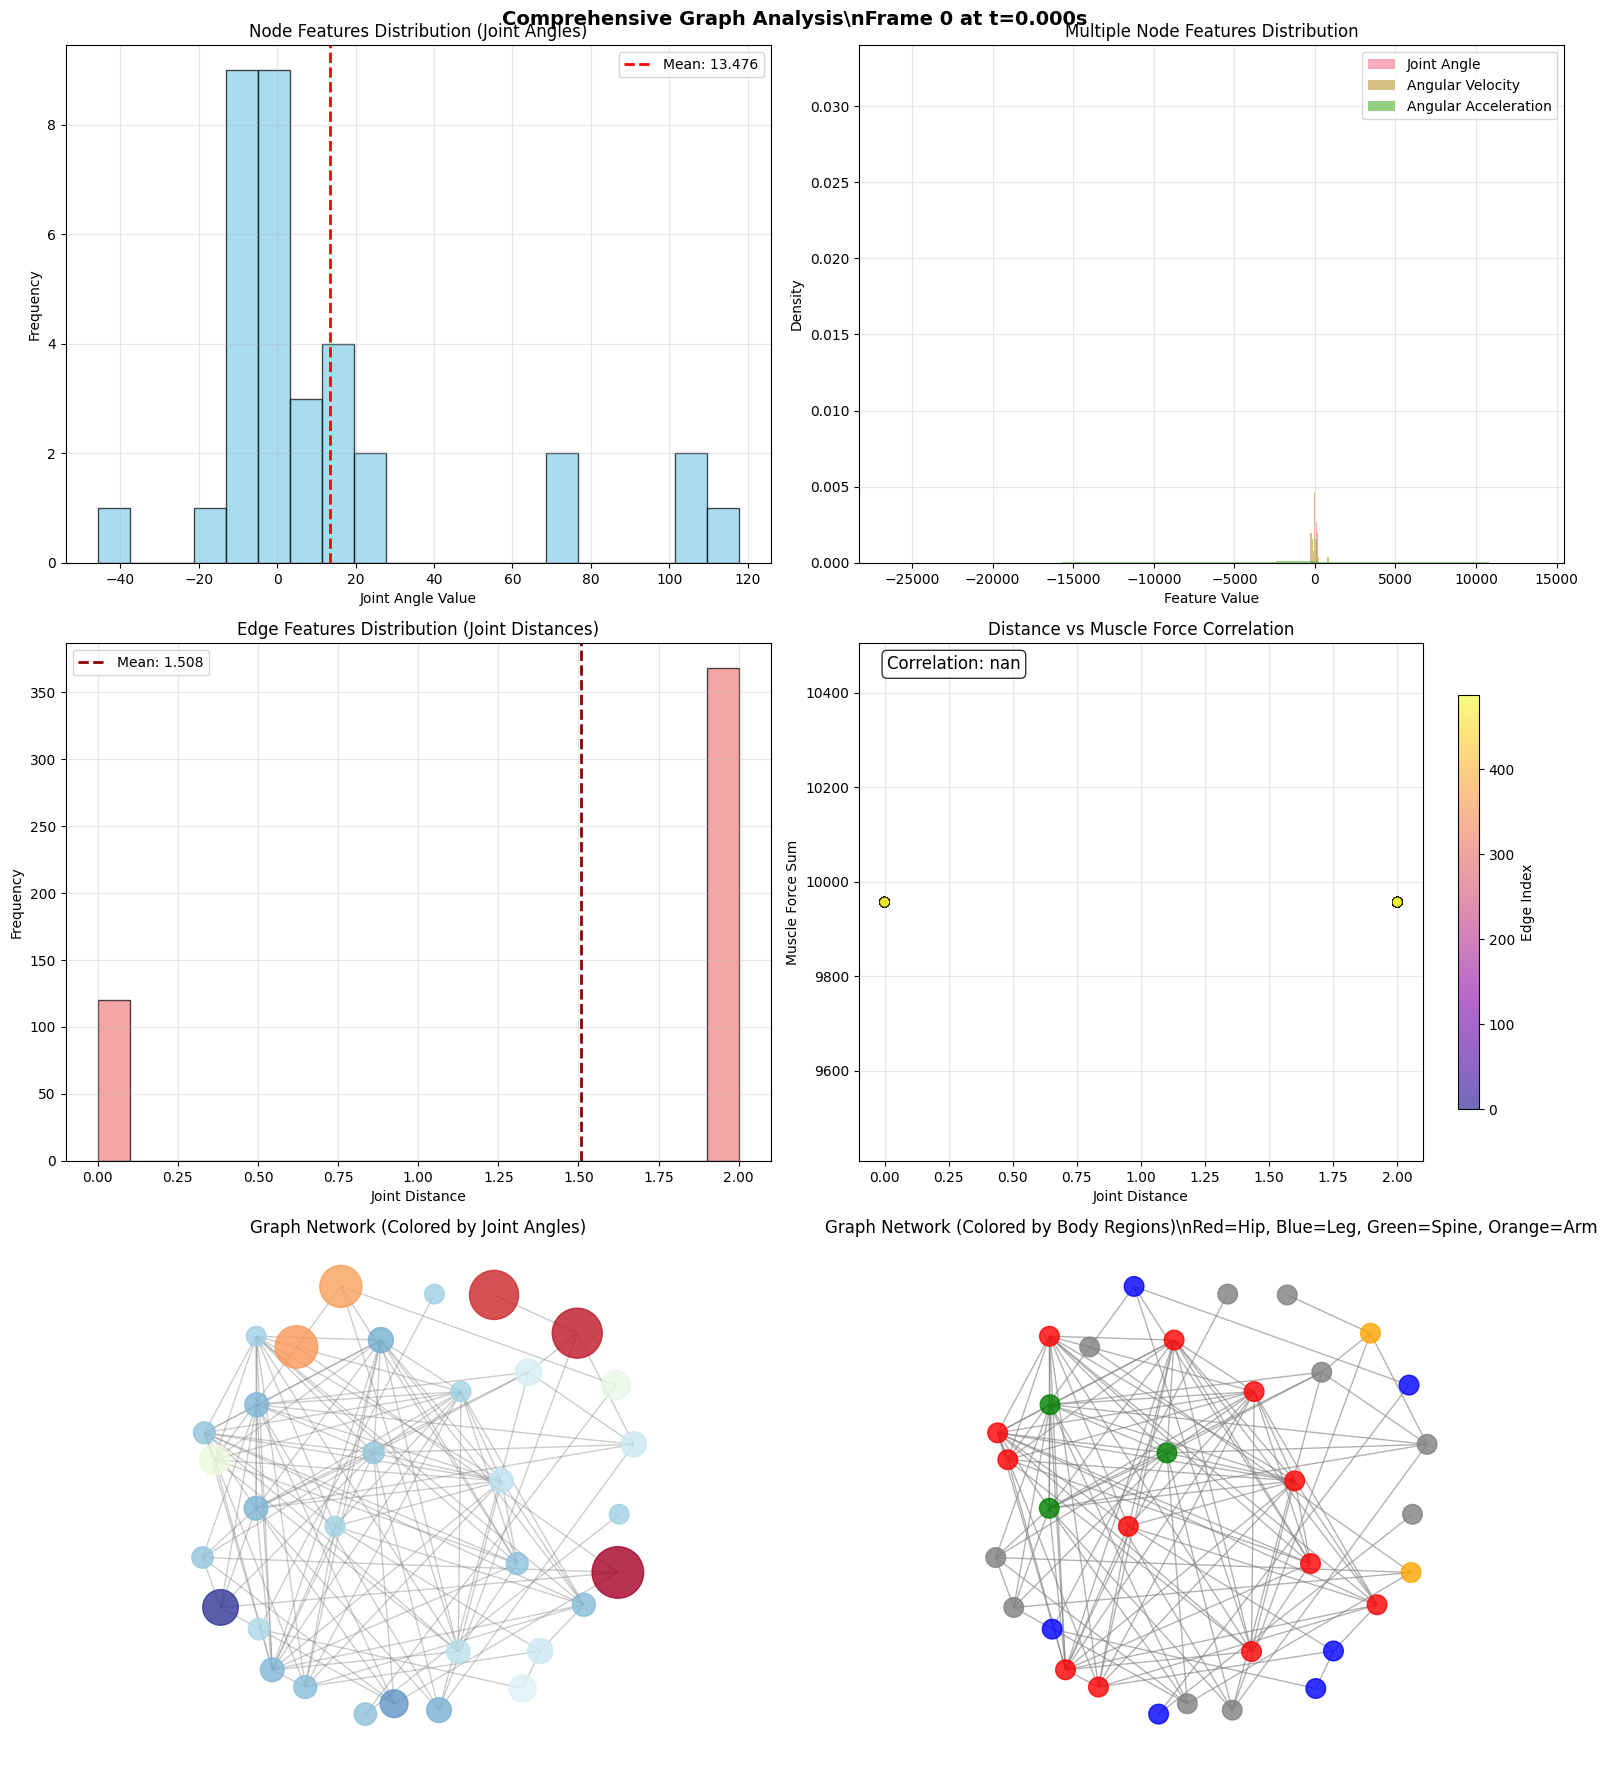

\n📊 Enhanced Graph Statistics:
   🎯 Time: 0.000s (frame 0)
   🔸 Nodes: 34 joints
   📈 Node features: 3 per joint
   🔗 Edges: 488 connections
   📊 Edge features: 5 per connection
\n📈 Node Feature Ranges:
   🎯 Joint angles: [-45.807, 117.706]
   ⚡ Angular velocities: [-277.755, 856.851]
   🚀 Angular accelerations: [-26315.703, 13468.994]
\n🔗 Edge Feature Ranges:
   📏 Joint distances: [0.000, 2.000]
   💪 Muscle forces: [9956.5, 9956.5]

📊 Dataset Summary:
   📈 Total frames: 94
   ⏰ Duration: 1.550s
   🔸 Nodes per graph: 34
   🔗 Edges per graph: 488
   📊 Node features: 3
   📋 Edge features: 5

🎯 Key Benefits of OpenSimGraphTimeSeriesDataset Class:

✅ **Unified Interface**: Single class for all OpenSim graph operations
✅ **Flexible Sequencing**: Custom sequence creation with overlap and stride
✅ **Multiple Export Formats**: NumPy, PyTorch Geometric, JSON configs
✅ **Easy Reloading**: Class methods for loading from exports
✅ **Comprehensive Analysis**: Built-in visualization and statistics
✅

In [94]:
## 12. Using the OpenSimGraphTimeSeriesDataset Class

print("🚀 Demonstrating the OpenSimGraphTimeSeriesDataset Class...")

# Example 1: Create a new dataset from scratch
print("\n📝 Example 1: Creating Dataset from Scratch")

# Create dataset instance
dataset = OpenSimGraphTimeSeriesDataset(
    model_path=test_osim,
    motion_path=test_mot,
    output_dir="demo_dataset"
)

print(f"\n📋 Dataset Info:")
print(dataset)

# Create frame graphs with derivatives
dataset.create_frame_graphs(add_derivatives=True)

# Create multiple sequence configurations
print(f"\n🔧 Creating Multiple Sequence Configurations...")

short_sequences = dataset.create_custom_sequences(sequence_length=5, overlap=0, stride=5)
medium_sequences = dataset.create_custom_sequences(sequence_length=8, overlap=6)
long_sequences = dataset.create_custom_sequences(sequence_length=15, overlap=2)

# Analyze different configurations
dataset.analyze_sequences(short_sequences, "Short Sequences")
dataset.analyze_sequences(medium_sequences, "Medium Sequences (75% Overlap)")
dataset.analyze_sequences(long_sequences, "Long Sequences")

# Save configurations
dataset.save_sequences_config(short_sequences, "short_config")
dataset.save_sequences_config(medium_sequences, "medium_config") 
dataset.save_sequences_config(long_sequences, "long_config")

# Export in multiple formats
numpy_file = dataset.export_numpy()
pytorch_file = dataset.export_pytorch_geometric()

print(f"\n💾 Exported Files:")
print(f"   📦 NumPy: {numpy_file}")
print(f"   🔥 PyTorch: {pytorch_file}")

# Create DataLoaders for different configurations
print(f"\n🔄 Creating DataLoaders...")

short_loader = dataset.get_dataloader(short_sequences, batch_size=8, shuffle=False)
medium_loader = dataset.get_dataloader(medium_sequences, batch_size=16, shuffle=True)
long_loader = dataset.get_dataloader(long_sequences, batch_size=4, shuffle=False)

print(f"✅ DataLoaders Created:")
print(f"   🔸 Short: {len(short_loader)} batches")
print(f"   🔸 Medium: {len(medium_loader)} batches") 
print(f"   🔸 Long: {len(long_loader)} batches")

# Example 2: Loading from saved data
print(f"\n📂 Example 2: Loading from Saved Data")

# Load from NumPy export
reloaded_dataset = OpenSimGraphTimeSeriesDataset.load_from_numpy(
    numpy_file, 
    output_dir="reloaded_dataset"
)

print(f"✅ Reloaded dataset: {len(reloaded_dataset.frame_graphs)} graphs")

# Create new sequences with different parameters
custom_sequences = reloaded_dataset.create_custom_sequences(
    sequence_length=12,
    overlap=4,
    stride=6
)

print(f"🔧 Created {len(custom_sequences)} custom sequences from reloaded data")

# Example 3: Comprehensive analysis and visualization
print(f"\n🎨 Example 3: Comprehensive Analysis")

# Visualize graph structure
dataset.visualize_graph_structure(graph_idx=0)

print(f"\n📊 Dataset Summary:")
print(f"   📈 Total frames: {len(dataset.frame_graphs)}")
print(f"   ⏰ Duration: {dataset.metadata['dataset_info']['time_span']['duration']:.3f}s")
print(f"   🔸 Nodes per graph: {dataset.metadata['dataset_info']['num_nodes']}")
print(f"   🔗 Edges per graph: {dataset.metadata['dataset_info']['num_edges']}")
print(f"   📊 Node features: {dataset.metadata['dataset_info']['node_features']}")
print(f"   📋 Edge features: {dataset.metadata['dataset_info']['edge_features']}")

print(f"\n🎯 Key Benefits of OpenSimGraphTimeSeriesDataset Class:")
print(f"""
✅ **Unified Interface**: Single class for all OpenSim graph operations
✅ **Flexible Sequencing**: Custom sequence creation with overlap and stride
✅ **Multiple Export Formats**: NumPy, PyTorch Geometric, JSON configs
✅ **Easy Reloading**: Class methods for loading from exports
✅ **Comprehensive Analysis**: Built-in visualization and statistics
✅ **DataLoader Integration**: Direct PyTorch Geometric DataLoader creation
✅ **Metadata Management**: Automatic tracking of dataset properties
✅ **Extensible Design**: Easy to add new features and analysis methods
""")

print("✅ OpenSimGraphTimeSeriesDataset demonstration complete!")

## 13. OpenSimGraphTimeSeriesDataset Quick Reference Guide

### 🎯 Class Overview
The `OpenSimGraphTimeSeriesDataset` class provides a comprehensive, unified interface for creating, managing, and analyzing OpenSim time-series graph datasets. It consolidates all functionality into a single, easy-to-use class.

### 🚀 Quick Start

```python
# Create new dataset
dataset = OpenSimGraphTimeSeriesDataset(
    model_path="path/to/model.osim",
    motion_path="path/to/motion.mot",
    output_dir="my_dataset"
)

# Create graphs with derivatives
dataset.create_frame_graphs(add_derivatives=True)

# Create sequences
sequences = dataset.create_custom_sequences(
    sequence_length=10, 
    overlap=5, 
    stride=2
)

# Export and save
dataset.export_numpy()
dataset.export_pytorch_geometric()
dataset.save_sequences_config(sequences, "my_config")

# Analyze and visualize
dataset.analyze_sequences(sequences)
dataset.visualize_graph_structure()
```

### 📚 Method Reference

#### **Core Data Loading**
- `load_model(model_path)`: Load OpenSim model file
- `load_motion(motion_path)`: Load OpenSim motion file

#### **Graph Creation**
- `create_frame_graphs(time_window, frame_step, add_derivatives)`: Create individual frame graphs
- `create_sequences(sequence_length, overlap, time_window)`: Create basic sequences
- `create_custom_sequences(graphs, sequence_length, overlap, stride)`: Create flexible sequences

#### **Export/Import**
- `export_numpy(filename)`: Export to NumPy format
- `export_pytorch_geometric(filename)`: Export to PyTorch Geometric format
- `load_from_numpy(numpy_path, metadata_path)`: Load from NumPy export
- `load_from_pytorch_geometric(pytorch_path)`: Load from PyTorch Geometric export

#### **Analysis and Visualization**
- `visualize_graph_structure(graph_idx)`: Comprehensive graph analysis plots
- `analyze_sequences(sequences, name)`: Analyze sequence properties
- `get_dataloader(sequences, batch_size, shuffle)`: Create PyTorch DataLoader

#### **Utility Functions**
- `save_sequences_config(sequences, config_name)`: Save sequence configuration
- `__repr__()`: Get dataset summary

### 🔧 Advanced Usage Patterns

#### **Multiple Sequence Configurations**
```python
# Create different sequence types for various use cases
short_sequences = dataset.create_custom_sequences(sequence_length=5, stride=5)      # Fast prototyping
medium_sequences = dataset.create_custom_sequences(sequence_length=8, overlap=6)   # High overlap
long_sequences = dataset.create_custom_sequences(sequence_length=15, overlap=2)    # Long context
strided_sequences = dataset.create_custom_sequences(sequence_length=10, stride=3)  # Downsampled

# Analyze each configuration
for sequences, name in [(short_sequences, "Short"), (medium_sequences, "Medium"), 
                       (long_sequences, "Long"), (strided_sequences, "Strided")]:
    dataset.analyze_sequences(sequences, name)
    dataset.save_sequences_config(sequences, f"{name.lower()}_config")
```

#### **Flexible Data Pipeline**
```python
# Load → Process → Export → Reload → Reprocess cycle
original_dataset = OpenSimGraphTimeSeriesDataset(model_path="model.osim", motion_path="motion.mot")
original_dataset.create_frame_graphs(add_derivatives=True)
numpy_file = original_dataset.export_numpy()

# Later: reload and create different sequences
reloaded_dataset = OpenSimGraphTimeSeriesDataset.load_from_numpy(numpy_file)
new_sequences = reloaded_dataset.create_custom_sequences(sequence_length=20, overlap=10)
```

#### **Integration with Graph Neural Networks**
```python
# Create sequences optimized for GNN training
train_sequences = dataset.create_custom_sequences(sequence_length=8, overlap=4)
val_sequences = dataset.create_custom_sequences(sequence_length=8, overlap=0, stride=8)

# Get DataLoaders for training
train_loader = dataset.get_dataloader(train_sequences, batch_size=32, shuffle=True)
val_loader = dataset.get_dataloader(val_sequences, batch_size=64, shuffle=False)

# Use in training loop
for batch in train_loader:
    # batch.x: node features [batch_size * num_nodes, num_features]
    # batch.edge_index: edge connectivity [2, batch_size * num_edges]
    # batch.edge_attr: edge features [batch_size * num_edges, num_edge_features]
    # batch.sequence_id: sequence identifier for each graph
    # batch.position_in_sequence: position within sequence
    pass
```

### 🎯 Use Case Recommendations

| **Use Case** | **Sequence Configuration** | **Parameters** |
|--------------|---------------------------|----------------|
| **Fast Prototyping** | Short sequences, no overlap | `sequence_length=5, stride=5` |
| **Real-time Applications** | Short sequences, minimal processing | `sequence_length=3-7, stride=sequence_length` |
| **Data Augmentation** | High overlap sequences | `sequence_length=8, overlap=6-7` |
| **Long-term Dependencies** | Long sequences, minimal overlap | `sequence_length=15-30, overlap=2-5` |
| **Computational Efficiency** | Strided sequences | `sequence_length=10, stride=3-5` |
| **Full Motion Analysis** | Single long sequence | `sequence_length=len(frames), overlap=0` |

### 🔄 Best Practices

1. **Always add derivatives** when creating frame graphs for richer features
2. **Experiment with overlap** - higher overlap = more data but also redundancy
3. **Use stride for efficiency** - skip frames when high temporal resolution isn't needed
4. **Save configurations** - export sequence configs for reproducibility
5. **Analyze before training** - use `analyze_sequences()` to understand your data
6. **Export early and often** - save processed data to avoid recomputation
7. **Visualize regularly** - use `visualize_graph_structure()` to catch issues

### 💡 Class Benefits Summary

✅ **Unified Interface**: All functionality in one place  
✅ **Flexible Sequencing**: Any sequence configuration you need  
✅ **Multiple Formats**: Export to NumPy, PyTorch Geometric, JSON  
✅ **Easy Reloading**: Seamless save/load workflow  
✅ **Rich Analysis**: Built-in visualization and statistics  
✅ **GNN Ready**: Direct DataLoader integration  
✅ **Extensible**: Easy to add new features  
✅ **Production Ready**: Handles real-world OpenSim data  

---

**The `OpenSimGraphTimeSeriesDataset` class is now your complete solution for OpenSim graph neural network datasets! 🚀**

In [95]:
## 10.8 Reload from PyTorch Geometric Dataset and Create Sequence Datasets

print("\n🔧 Advanced: Creating Sequence-Aware PyTorch Geometric Datasets...")

from torch_geometric.data import Dataset, InMemoryDataset
import pickle

class OpenSimSequenceDataset(InMemoryDataset):
    """
    Custom PyTorch Geometric Dataset for OpenSim sequences
    Each sample is a complete sequence of graphs
    """
    def __init__(self, root, sequence_config='medium', transform=None, pre_transform=None, pre_filter=None):
        self.sequence_config = sequence_config
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
    
    @property
    def raw_file_names(self):
        return [f'{self.sequence_config}_sequence_data.pkl']
    
    @property 
    def processed_file_names(self):
        return [f'{self.sequence_config}_sequence_data.pt']
    
    def download(self):
        # No download needed - data is already processed
        pass
    
    def process(self):
        # Load raw sequence data
        with open(self.raw_paths[0], 'rb') as f:
            raw_data = pickle.load(f)
        
        data_list = []
        for seq_idx, sequence in enumerate(raw_data['sequences']):
            # Create a batch of graphs for this sequence
            sequence_graphs = sequence['graphs']
            
            # Stack all graphs in sequence into batch format
            batch_x = torch.stack([g.x for g in sequence_graphs], dim=0)  # [seq_len, nodes, features]
            batch_edge_index = sequence_graphs[0].edge_index  # Same for all frames
            batch_edge_attr = torch.stack([g.edge_attr for g in sequence_graphs], dim=0) if sequence_graphs[0].edge_attr is not None else None
            
            # Create sequence data object
            data = Data(
                x=batch_x,  # [sequence_length, num_nodes, num_features]
                edge_index=batch_edge_index,  # [2, num_edges] - same connectivity for all frames
                edge_attr=batch_edge_attr,  # [sequence_length, num_edges, num_edge_features] if available
                sequence_length=torch.tensor([sequence['sequence_length']], dtype=torch.long),
                start_time=torch.tensor([sequence['start_time']], dtype=torch.float),
                end_time=torch.tensor([sequence['end_time']], dtype=torch.float),
                sequence_id=torch.tensor([seq_idx], dtype=torch.long)
            )
            
            data_list.append(data)
        
        # Apply pre-filtering and pre-transforms if specified
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]
        
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        
        # Collate data
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

# Check if we have reloaded graphs from previous cell
if 'reloaded_graphs' in locals() and len(reloaded_graphs) > 0:
    
    print("📊 Creating Sequence Datasets for Different Configurations...")
    
    # Prepare sequence datasets
    sequence_dataset_root = Path("../opensim_sequence_datasets")
    sequence_dataset_root.mkdir(exist_ok=True)
    
    # Create different sequence configurations
    sequence_configs = {
        'short': {'length': 5, 'overlap': 0, 'stride': 5},
        'medium': {'length': 8, 'overlap': 6, 'stride': 2},
        'long': {'length': 15, 'overlap': 3, 'stride': 12},
        'strided': {'length': 10, 'overlap': 0, 'stride': 3}
    }
    
    created_datasets = {}
    
    for config_name, config_params in sequence_configs.items():
        print(f"\n🔧 Creating {config_name} sequence dataset...")
        
        # Create sequences
        sequences = create_custom_sequences(
            reloaded_graphs,
            sequence_length=config_params['length'],
            overlap=config_params['overlap'],
            stride=config_params['stride']
        )
        
        if sequences:
            # Prepare dataset directory
            config_root = sequence_dataset_root / config_name
            config_root.mkdir(exist_ok=True)
            raw_dir = config_root / "raw"
            raw_dir.mkdir(exist_ok=True)
            
            # Prepare raw data
            raw_data = {
                'sequences': sequences,
                'config': config_params,
                'metadata': {
                    'num_sequences': len(sequences),
                    'sequence_length': config_params['length'],
                    'overlap': config_params['overlap'],
                    'stride': config_params['stride'],
                    'total_graphs': sum(len(seq['graphs']) for seq in sequences)
                }
            }
            
            # Save raw data
            raw_file = raw_dir / f"{config_name}_sequence_data.pkl"
            with open(raw_file, 'wb') as f:
                pickle.dump(raw_data, f)
            
            # Create dataset
            try:
                dataset = OpenSimSequenceDataset(root=str(config_root), sequence_config=config_name)
                created_datasets[config_name] = dataset
                
                print(f"   ✅ {config_name}: {len(dataset)} sequences")
                print(f"      📏 Sequence length: {config_params['length']}")
                print(f"      🔄 Overlap: {config_params['overlap']}")
                print(f"      📊 Sample shape: {dataset[0].x.shape}")  # [seq_len, nodes, features]
                
            except Exception as e:
                print(f"   ❌ Error creating {config_name} dataset: {e}")
    
    ## 10.9 Demonstrate Usage of Sequence Datasets
    
    if created_datasets:
        print(f"\n🚀 Demonstrating Sequence Dataset Usage...")
        
        # Use medium dataset as example
        if 'medium' in created_datasets:
            medium_seq_dataset = created_datasets['medium']
            
            print(f"\n📊 Medium Sequence Dataset Analysis:")
            print(f"   🔸 Total sequences: {len(medium_seq_dataset)}")
            
            # Get a sample sequence
            sample_sequence = medium_seq_dataset[0]
            print(f"   📈 Sample sequence shape: {sample_sequence.x.shape}")
            print(f"   ⏰ Time span: {sample_sequence.start_time.item():.3f}s to {sample_sequence.end_time.item():.3f}s")
            print(f"   📏 Length: {sample_sequence.sequence_length.item()} frames")
            
            # Create DataLoader for sequences
            from torch_geometric.loader import DataLoader
            seq_loader = DataLoader(medium_seq_dataset, batch_size=4, shuffle=True)
            
            print(f"   📦 DataLoader: {len(seq_loader)} batches")
            
            # Demonstrate batch loading
            sample_batch = next(iter(seq_loader))
            print(f"\n📦 Sample Batch Analysis:")
            print(f"   📊 Batch size: {sample_batch.sequence_length.shape[0]}")
            print(f"   📈 Batch shape: {sample_batch.x.shape}")  # [batch_size, seq_len, nodes, features]
            print(f"   ⏰ Time range: {sample_batch.start_time.min().item():.3f}s to {sample_batch.end_time.max().item():.3f}s")
    
    ## 10.10 Advanced Usage Examples
    
    print(f"\n💡 Advanced Usage Examples:")
    
    print(f"""
    🔧 **Example 1: Sequence-to-Sequence Prediction**
    ```python
    # Load sequence dataset
    dataset = OpenSimSequenceDataset(root='opensim_sequence_datasets/medium')
    loader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    for batch in loader:
        # batch.x shape: [batch_size, sequence_length, num_nodes, num_features]
        input_sequence = batch.x[:, :-1]  # All but last frame
        target_sequence = batch.x[:, 1:]  # All but first frame
        
        # Train sequence-to-sequence model
        predictions = model(input_sequence)
        loss = criterion(predictions, target_sequence)
    ```
    
    🔧 **Example 2: Variable Length Sequences**
    ```python
    # Create custom sequences with different lengths
    short_seqs = create_custom_sequences(graphs, sequence_length=5, overlap=1)
    long_seqs = create_custom_sequences(graphs, sequence_length=20, overlap=5)
    
    # Combine different length sequences for robust training
    mixed_sequences = short_seqs + long_seqs
    ```
    
    🔧 **Example 3: Temporal Attention Analysis**
    ```python
    # Use sequences for attention-based models
    for batch in seq_loader:
        # batch.x: [batch, seq_len, nodes, features]
        # Apply temporal attention across sequence dimension
        attention_weights = temporal_attention(batch.x)
        # Focus on important time steps for each joint
    ```
    
    🔧 **Example 4: Motion Phase Detection**
    ```python
    # Analyze different phases within sequences
    for sequence in dataset:
        seq_data = sequence.x  # [seq_len, nodes, features]
        
        # Detect stance/swing phases in gait
        phases = detect_gait_phases(seq_data)
        
        # Use phase information for specialized training
    ```
    """)
    
    print(f"✅ Advanced sequence dataset creation complete!")
    print(f"🎯 You now have multiple ways to work with temporal graph sequences!")

else:
    print("⚠️ Reloaded graphs not available. Please run the previous reloading section first.")


🔧 Advanced: Creating Sequence-Aware PyTorch Geometric Datasets...
📊 Creating Sequence Datasets for Different Configurations...

🔧 Creating short sequence dataset...
   ✅ short: 6 sequences
      📏 Sequence length: 5
      🔄 Overlap: 0
      📊 Sample shape: torch.Size([5, 34, 3])

🔧 Creating medium sequence dataset...
   ✅ medium: 12 sequences
      📏 Sequence length: 8
      🔄 Overlap: 6
      📊 Sample shape: torch.Size([8, 34, 3])

🔧 Creating long sequence dataset...
   ✅ long: 2 sequences
      📏 Sequence length: 15
      🔄 Overlap: 3
      📊 Sample shape: torch.Size([15, 34, 3])

🔧 Creating strided sequence dataset...
   ✅ strided: 8 sequences
      📏 Sequence length: 10
      🔄 Overlap: 0
      📊 Sample shape: torch.Size([10, 34, 3])

🚀 Demonstrating Sequence Dataset Usage...

📊 Medium Sequence Dataset Analysis:
   🔸 Total sequences: 12
   📈 Sample sequence shape: torch.Size([8, 34, 3])
   ⏰ Time span: 0.000s to 0.233s
   📏 Length: 8 frames
   📦 DataLoader: 3 batches

📦 Sample Bat

# 📋 **Quick Reference: Data Reloading & Re-sequencing**

## 🔄 **Reloading Options**

### **Option 1: From NumPy Export**
```python
# Load individual graphs
graphs_data = np.load('opensim_graph_dataset/frame_graphs.npz', allow_pickle=True)
frame_graphs = graphs_data['graphs']

# Convert to PyTorch Geometric
reloaded_graphs = []
for graph_dict in frame_graphs:
    data = Data(
        x=torch.tensor(graph_dict['node_features'], dtype=torch.float),
        edge_index=torch.tensor(graph_dict['edge_index'], dtype=torch.long),
        edge_attr=torch.tensor(graph_dict['edge_attr'], dtype=torch.float),
        time=graph_dict['time'],
        frame_idx=graph_dict['frame_idx']
    )
    reloaded_graphs.append(data)
```

### **Option 2: From PyTorch Geometric Dataset**
```python
# Load the dataset directly
dataset = OpenSimGraphDataset(root='opensim_pyg_dataset')
loader = DataLoader(dataset, batch_size=32, shuffle=False)
```

## 🔧 **Re-sequencing Parameters**

| Parameter | Description | Example Values | Best For |
|-----------|-------------|----------------|----------|
| `sequence_length` | Frames per sequence | 5, 8, 10, 15, 20 | Task complexity |
| `overlap` | Overlapping frames | 0, 2, 4, 6 | Data augmentation |
| `stride` | Step between starts | 1, 3, 5 | Temporal sampling |

## 🎯 **Common Re-sequencing Patterns**

### **Fast Prototyping**
```python
sequences = create_custom_sequences(graphs, sequence_length=5, overlap=0, stride=5)
```

### **Dense Temporal Coverage**
```python
sequences = create_custom_sequences(graphs, sequence_length=10, overlap=8, stride=2)
```

### **Memory Efficient**
```python
sequences = create_custom_sequences(graphs, sequence_length=8, overlap=0, stride=4)
```

### **Long-term Dependencies**
```python
sequences = create_custom_sequences(graphs, sequence_length=20, overlap=5, stride=15)
```

## 📊 **Sequence Dataset Types**

1. **Individual Graph Dataset**: Each graph is a separate sample
2. **Sequence Dataset**: Each sequence is a sample (batch of graphs)
3. **Mixed Dataset**: Combines different sequence lengths

## 🚀 **Ready for Advanced Applications!**

- ✅ Motion Prediction Models
- ✅ Temporal Pattern Analysis  
- ✅ Biomechanical Phase Detection
- ✅ Real-time Motion Processing
- ✅ Multi-scale Temporal Learning